#### Now create a multiclass problem 
Here we will include all classes so basically we have to load the data again, it will almost be the same code as for binary classification

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import svd, norm
#from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from PIL import Image
import ast
from tqdm import tqdm
from sklearn.decomposition import TruncatedSVD
from sklearn import datasets, svm, metrics
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
#Import naive bayes
from sklearn.naive_bayes import GaussianNB
#import Knn
from sklearn.neighbors import KNeighborsClassifier
#Import confusion matrixdisplay
from sklearn.metrics import ConfusionMatrixDisplay
#For truncated svd, we need to import the base estimator and classifier mixin
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

#For multilabel classification
from sklearn.multioutput import MultiOutputClassifier


In [35]:
test1 = train_data[train_data['is_fault']]

In [47]:
test1

ImageDir  \
21     VitusData/Serier/Series6/CellsCorr/Serie_6_Ima...   
130    VitusData/Serier/Series1/CellsCorr/Serie_1_Ima...   
206    VitusData/Serier/Series1/CellsCorr/Serie_1_Ima...   
300    VitusData/Serier/Series6/CellsCorr/Serie_6_Ima...   
400    VitusData/Serier/Series5/CellsCorr/Serie_5_Ima...   
...                                                  ...   
21183  VitusData/Serier/Series1/CellsCorr/Serie_1_Ima...   
21201  VitusData/Serier/Series6/CellsCorr/Serie_6_Ima...   
21222  VitusData/Serier/Series1/CellsCorr/Serie_1_Ima...   
21313  VitusData/Serier/Series1/CellsCorr/Serie_1_Ima...   
21596  VitusData/Serier/Series1/CellsCorr/Serie_1_Ima...   

                                                   Label  \
21                                            ['CrackC']   
130                                    ['FingerFailure']   
206    ['CrackA', 'CrackB', 'FingerFailure', 'FingerF...   
300                                           ['CrackB']   
400                                           ['CrackA']   
...                                                  ...   
21183                                  ['FingerFailure']   
21201                                         ['CrackC']   
21222  ['CrackA', 'FingerFailure', 'FingerFailure', '...   
21313                                  ['FingerFailure']   
21596                                         ['CrackB']   

                                                 MaskDir  is_fault  
21     ['VitusData/Masks/-20_4280_PC_Cell_Row6_Col_4_...      True  
130    ['VitusData/Masks/-5_4106_Cell_Row9_Col_6_Fing...      True  
206    ['VitusData/Masks/-12_4124_Cell_Row4_Col_2_Cra...      True  
300    ['VitusData/Masks/-4_4225_PC_Cell_Row4_Col_3_C...      True  
400    ['VitusData/Masks/-3_3928_Cell_Row5_Col_7_Crac...      True  
...                                                  ...       ...  
21183  ['VitusData/Masks/-10_4104_Cell_Row1_Col_3_Fin...      True  
21201  ['VitusData/Masks/-18_4260_PC_Cell_Row7_Col_4_...      True  
21222  ['VitusData/Masks/-12_4124_Cell_Row4_Col_1_Cra...      True  
21313  ['VitusData/Masks/-16_4102_Cell_Row4_Col_1_Fin...      True  
21596  ['VitusData/Masks/-3_4140_Cell_Row5_Col_4_Crac...      True  

[306 rows x 4 columns]

In [39]:
test1.loc[400]

ImageDir    VitusData/Serier/Series5/CellsCorr/Serie_5_Ima...
Label                                              ['CrackA']
MaskDir     ['VitusData/Masks/-3_3928_Cell_Row5_Col_7_Crac...
is_fault                                                 True
Name: 400, dtype: object

(334, 333)


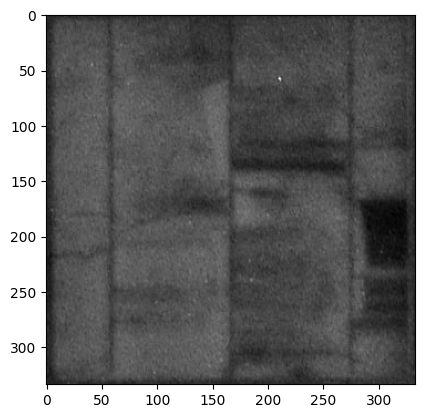

In [59]:
plt.imshow(load_image(test1.loc[206]['ImageDir']),cmap = 'gray')

(224, 224)


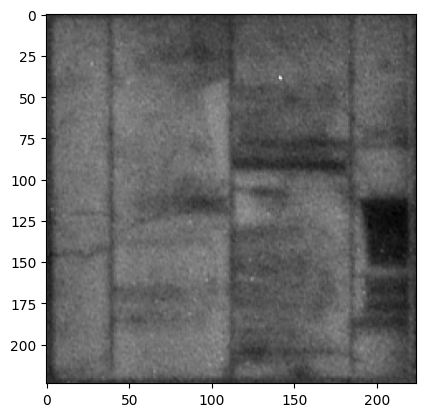

In [61]:
plt.imshow(load_image(test1.loc[206]['ImageDir']),cmap = 'gray')

In [60]:
def load_image(path):
    img = Image.open(f'{base_dir}{path}')
    #Resize the image to 320x320
    img = img.resize((224, 224))
    img = np.array(img)
    print(img.shape)
    #img = np.array(img)
    #img = img.flatten()
    #img = img.reshape((-1,1))
    return img

In [65]:
def load_image(path):
    img = Image.open(f'{base_dir}{path}')
    print(img.size)
    #Resize the image to 320x320
    img = img.resize((320, 320))
    img = np.array(img)
    img = img.flatten()
    img = img.reshape((-1,1))
    return img

def one_hot_encode(label):
    # One hot encoding
    place_holder = [0, 0, 0, 0, 0]
    if 'CrackA' in label:
        place_holder[0] = 1
    if 'CrackB' in label:
        place_holder[1] = 1
    if 'CrackC' in label:
        place_holder[2] = 1
    if 'FingerFailure' in label:
        place_holder[3] = 1
    if 'Negative' in label:
        place_holder[4] = 1
    return place_holder

def get_images(data, M=102,train=True):
    # Load the data such that the collumns of X is the image as a vector
    # Initialize np array of size (320*320,len(data))
    X = [] #np.zeros(((320 * 320),M*2))
    y = []#[None] * (M*2)
    neg_count = 0
    pos_count = 0
    for (i, row) in tqdm(data.iterrows()):
        #Get the label
        label = ast.literal_eval(row['Label'])
        lab_encoding = one_hot_encode(label)
        
        if lab_encoding[4] == 1 and neg_count < M:
            im = load_image(row['ImageDir'])
            X.append(im)
            y.append(lab_encoding)
            if train:
                neg_count += 1
        elif not lab_encoding[4]:
            im = load_image(row['ImageDir'])
            X.append(im)
            y.append(lab_encoding)
            if train:
                pos_count += 1
        elif neg_count >= M and pos_count >= M:
            print("What")
            break
        else:
            continue
    X = np.array(X)
    X = X.T #We want the collumns to be the images
    return X, np.array(y)

In [66]:
# Load the data
train_data = pd.read_csv('/Users/madsandersen/PycharmProjects/BscProjektData/BachelorProject/Data/VitusData/Train.csv')
train_data = train_data.drop(['Unnamed: 0'], axis=1)
test_data = pd.read_csv('/Users/madsandersen/PycharmProjects/BscProjektData/BachelorProject/Data/VitusData/Val.csv')
test_data = test_data.drop(['Unnamed: 0'], axis=1)
base_dir = '/Users/madsandersen/PycharmProjects/BscProjektData/BachelorProject/Data/'

# Training data size
M = 60 # Number of images

In [67]:
#Create the X and y matrices
X_train,y_train = get_images(train_data,train=True)
X_test,y_test = get_images(test_data,train=False)

66it [00:00, 339.48it/s]

(304, 300)
(302, 301)
(295, 300)
(303, 302)
(321, 322)
(299, 298)
(329, 328)
(303, 295)
(301, 301)
(300, 300)
(297, 301)
(302, 302)
(323, 322)
(320, 321)
(298, 299)
(302, 301)
(302, 299)
(329, 328)
(311, 312)
(302, 292)
(309, 302)
(302, 301)
(298, 300)
(318, 317)
(295, 299)
(325, 325)
(305, 306)
(295, 300)
(315, 310)
(295, 294)
(288, 291)
(299, 299)
(314, 315)
(296, 301)
(301, 299)
(313, 312)
(302, 304)
(315, 310)
(299, 300)
(294, 301)
(303, 302)
(291, 293)
(302, 300)
(296, 300)
(311, 300)
(332, 325)
(301, 298)
(411, 405)
(301, 300)
(301, 302)
(331, 331)
(303, 301)
(304, 300)
(320, 320)
(302, 300)
(291, 291)
(291, 301)
(300, 301)
(303, 300)
(274, 270)
(294, 303)
(315, 312)
(297, 302)
(303, 301)
(302, 292)
(302, 302)
(296, 293)


2532it [00:00, 9482.27it/s]

(285, 289)
(303, 301)
(310, 295)
(303, 301)
(329, 329)
(315, 315)
(303, 301)
(298, 299)
(302, 302)
(317, 315)
(301, 300)
(301, 300)
(293, 294)
(299, 299)
(303, 300)
(296, 300)
(302, 297)
(302, 300)
(297, 302)
(302, 302)
(301, 301)
(317, 318)
(302, 301)
(306, 307)
(303, 301)
(315, 314)
(301, 301)
(302, 302)
(301, 301)
(293, 301)
(316, 316)
(298, 301)
(301, 296)
(303, 302)
(302, 302)
(334, 332)
(323, 327)
(333, 334)
(301, 297)
(293, 290)
(323, 321)
(323, 323)
(301, 301)
(302, 301)
(302, 301)
(322, 320)
(302, 301)
(314, 316)
(314, 316)
(310, 311)
(324, 324)
(303, 301)
(310, 310)
(411, 405)
(301, 301)
(310, 308)
(310, 308)
(294, 296)
(320, 319)
(332, 333)
(325, 325)
(311, 309)
(321, 320)
(325, 324)


6635it [00:00, 15800.00it/s]

(294, 303)
(323, 323)
(324, 325)
(310, 311)
(301, 300)
(303, 301)
(318, 310)
(320, 322)
(323, 323)
(330, 329)
(315, 314)
(319, 318)
(302, 299)
(301, 301)
(310, 311)
(301, 301)
(311, 312)
(407, 406)
(300, 308)
(297, 302)
(303, 302)
(302, 301)
(303, 298)
(328, 327)
(397, 398)
(301, 301)
(332, 328)
(393, 395)
(323, 321)
(409, 408)
(306, 307)
(319, 319)
(319, 322)
(320, 318)
(333, 332)
(300, 302)
(303, 300)
(301, 300)
(319, 319)
(302, 302)
(322, 318)
(302, 300)
(322, 321)
(302, 302)
(321, 319)
(321, 320)
(293, 293)
(329, 329)
(403, 405)


8879it [00:00, 12491.79it/s]


(318, 308)
(302, 301)
(329, 327)
(302, 300)
(319, 318)
(301, 301)
(302, 292)
(303, 302)
(420, 416)
(302, 303)
(302, 300)
(322, 323)
(302, 302)
(302, 301)
(301, 301)
(318, 318)
(328, 328)
(319, 321)
(318, 317)
(309, 306)
(401, 395)
(314, 313)
(316, 317)
(318, 319)
What


0it [00:00, ?it/s]

(301, 301)
(301, 301)
(301, 299)
(303, 301)
(417, 418)
(299, 301)
(342, 335)
(409, 406)
(292, 300)
(302, 301)
(299, 300)
(302, 301)
(302, 294)
(297, 295)
(300, 298)
(294, 296)
(300, 304)
(302, 300)
(302, 299)
(302, 301)
(302, 301)
(304, 295)
(303, 301)
(291, 291)
(397, 396)
(252, 292)
(328, 328)
(296, 303)
(310, 308)
(296, 295)
(323, 324)
(302, 302)
(298, 295)
(299, 302)
(303, 302)
(295, 299)
(299, 298)
(301, 302)
(302, 301)


41it [00:00, 396.33it/s]

(295, 302)
(414, 410)
(297, 301)
(294, 293)
(297, 296)
(302, 301)
(316, 316)
(296, 301)
(298, 295)
(302, 300)
(296, 300)
(304, 300)
(302, 303)
(301, 300)
(311, 310)
(302, 296)
(300, 300)
(302, 301)
(291, 301)
(302, 303)
(331, 332)
(302, 297)
(302, 301)
(303, 302)
(300, 302)
(319, 324)
(302, 301)
(303, 300)
(321, 321)
(303, 301)
(329, 329)
(301, 292)
(293, 299)
(304, 301)
(293, 303)
(292, 300)
(262, 260)
(294, 301)
(304, 301)
(301, 299)
(314, 315)
(315, 316)
(323, 322)


83it [00:00, 409.44it/s]

(303, 300)
(337, 333)
(295, 293)
(322, 329)
(294, 301)
(324, 321)
(259, 297)
(302, 305)
(302, 301)
(309, 306)
(326, 324)
(301, 302)
(317, 318)
(408, 417)
(301, 291)
(294, 301)
(303, 301)
(274, 275)
(317, 318)
(296, 295)
(315, 317)
(301, 300)
(312, 313)
(297, 303)
(319, 319)
(302, 301)
(302, 302)
(292, 302)
(303, 300)
(409, 405)
(307, 308)
(301, 290)
(309, 309)
(297, 296)
(315, 314)
(298, 294)
(302, 299)
(293, 293)
(305, 301)
(300, 302)


124it [00:00, 407.64it/s]

(294, 294)
(294, 301)
(297, 301)
(303, 303)
(301, 300)
(296, 301)
(305, 306)
(302, 302)
(322, 327)
(304, 306)
(303, 302)
(298, 302)
(292, 301)
(303, 302)
(295, 299)
(302, 300)
(297, 296)
(300, 332)
(291, 291)
(301, 300)
(296, 300)
(303, 301)
(302, 300)
(302, 300)
(294, 300)
(300, 303)
(303, 299)
(303, 293)
(298, 301)
(302, 301)
(296, 294)
(290, 289)
(316, 315)
(329, 329)
(300, 302)
(301, 301)
(316, 317)
(302, 302)
(302, 301)
(293, 303)
(301, 301)
(301, 304)
(315, 315)


166it [00:00, 410.79it/s]

(295, 301)
(301, 300)
(301, 301)
(302, 300)
(281, 281)
(404, 403)
(312, 313)
(302, 299)
(298, 301)
(304, 302)
(319, 320)
(307, 308)
(301, 302)
(302, 301)
(300, 300)
(301, 298)
(294, 299)
(301, 299)
(303, 302)
(333, 331)
(294, 297)
(296, 300)
(299, 302)
(303, 301)
(302, 296)
(302, 303)
(300, 301)
(303, 302)
(303, 300)
(301, 294)
(316, 317)
(295, 300)
(297, 300)
(302, 295)
(295, 294)
(324, 324)
(298, 299)
(297, 287)
(336, 334)
(295, 293)
(304, 300)


208it [00:00, 412.82it/s]

(295, 292)
(323, 322)
(301, 301)
(301, 301)
(302, 296)
(300, 299)
(303, 302)
(316, 316)
(302, 295)
(322, 321)
(300, 290)
(332, 331)
(302, 299)
(302, 301)
(301, 300)
(308, 307)
(294, 301)
(301, 302)
(303, 303)
(298, 300)
(298, 300)
(314, 316)
(298, 299)
(302, 301)
(297, 301)
(301, 301)
(303, 301)
(302, 298)
(297, 302)
(302, 298)
(318, 323)
(301, 297)
(301, 301)
(300, 301)
(302, 301)
(302, 300)
(323, 321)
(332, 333)
(308, 309)
(294, 302)
(301, 298)
(403, 394)
(307, 305)


250it [00:00, 411.79it/s]

(301, 299)
(302, 303)
(298, 302)
(301, 300)
(292, 295)
(300, 298)
(299, 299)
(302, 301)
(302, 302)
(299, 297)
(292, 290)
(302, 300)
(297, 297)
(302, 299)
(298, 300)
(302, 298)
(313, 311)
(298, 302)
(301, 295)
(303, 301)
(302, 300)
(303, 300)
(302, 300)
(297, 300)
(293, 292)
(303, 302)
(300, 302)
(306, 308)
(301, 295)
(294, 293)
(303, 303)
(297, 300)
(314, 316)
(326, 327)
(302, 301)
(299, 301)
(296, 301)
(295, 301)
(274, 275)
(323, 320)
(302, 303)


292it [00:00, 413.11it/s]

(302, 301)
(301, 301)
(311, 318)
(300, 301)
(296, 301)
(303, 301)
(293, 295)
(302, 300)
(309, 310)
(311, 314)
(294, 301)
(401, 392)
(317, 320)
(294, 302)
(297, 295)
(298, 298)
(302, 301)
(296, 296)
(294, 301)
(302, 302)
(302, 301)
(294, 302)
(291, 293)
(302, 294)
(303, 292)
(297, 297)
(295, 300)
(302, 300)
(302, 300)
(301, 300)
(302, 303)
(303, 300)
(303, 300)
(301, 302)
(302, 301)
(302, 301)
(302, 295)
(294, 300)
(301, 301)
(321, 324)
(303, 294)
(301, 299)
(315, 314)


334it [00:00, 414.72it/s]

(297, 291)
(324, 321)
(303, 302)
(309, 307)
(293, 297)
(295, 303)
(302, 302)
(395, 399)
(303, 301)
(296, 294)
(302, 300)
(301, 299)
(302, 302)
(302, 307)
(302, 302)
(302, 298)
(294, 296)
(297, 292)
(319, 319)
(303, 298)
(299, 296)
(301, 299)
(302, 299)
(301, 301)
(305, 303)
(302, 297)
(301, 298)
(303, 301)
(303, 297)
(291, 290)
(318, 317)
(323, 318)
(301, 300)
(314, 314)
(303, 301)
(291, 290)
(302, 299)
(301, 298)
(303, 301)
(308, 307)
(320, 321)


376it [00:00, 412.94it/s]

(302, 302)
(285, 286)
(293, 293)
(300, 300)
(300, 296)
(301, 294)
(301, 293)
(301, 299)
(301, 301)
(303, 301)
(302, 301)
(295, 302)
(294, 301)
(318, 320)
(296, 300)
(300, 299)
(299, 299)
(302, 302)
(301, 302)
(296, 301)
(316, 320)
(302, 300)
(301, 301)
(294, 301)
(302, 300)
(302, 302)
(305, 307)
(309, 308)
(314, 312)
(301, 300)
(297, 302)
(290, 299)
(306, 307)
(303, 301)
(300, 301)
(305, 305)
(299, 300)
(303, 301)
(300, 303)
(302, 300)
(315, 316)
(306, 308)


418it [00:01, 411.04it/s]

(302, 300)
(301, 299)
(315, 315)
(301, 300)
(420, 418)
(302, 299)
(301, 302)
(315, 316)
(301, 300)
(308, 307)
(303, 301)
(255, 300)
(317, 319)
(301, 302)
(297, 302)
(301, 297)
(301, 301)
(302, 299)
(321, 316)
(329, 330)
(325, 328)
(300, 300)
(297, 302)
(314, 313)
(294, 301)
(301, 301)
(410, 411)
(299, 298)
(310, 309)
(303, 299)
(304, 301)
(292, 291)
(294, 301)
(293, 301)
(302, 301)
(294, 301)
(314, 314)
(300, 301)
(302, 300)


460it [00:01, 405.84it/s]

(316, 316)
(303, 302)
(302, 301)
(301, 300)
(303, 301)
(302, 304)
(302, 300)
(297, 301)
(303, 298)
(318, 317)
(293, 291)
(299, 297)
(294, 302)
(302, 302)
(303, 303)
(304, 300)
(297, 300)
(301, 289)
(302, 292)
(318, 316)
(296, 294)
(303, 301)
(302, 303)
(296, 293)
(323, 322)
(295, 304)
(303, 302)
(302, 296)
(395, 395)
(302, 302)
(301, 298)
(299, 301)
(294, 301)
(292, 293)
(322, 322)
(301, 301)
(302, 302)
(310, 311)
(312, 315)
(298, 302)
(310, 310)


501it [00:01, 404.04it/s]

(302, 291)
(313, 312)
(303, 302)
(303, 292)
(318, 319)
(312, 313)
(301, 300)
(301, 298)
(317, 317)
(308, 301)
(271, 274)
(324, 324)
(303, 301)
(301, 301)
(301, 301)
(295, 300)
(294, 295)
(330, 331)
(412, 417)
(291, 288)
(294, 296)
(303, 296)
(299, 298)
(301, 297)
(403, 404)
(294, 296)
(302, 299)
(300, 301)
(295, 301)
(294, 295)
(330, 334)
(294, 302)
(303, 301)
(308, 309)
(319, 318)
(309, 314)
(328, 328)
(312, 312)
(314, 314)
(310, 308)


542it [00:01, 401.13it/s]

(313, 312)
(301, 300)
(303, 304)
(302, 303)
(304, 301)
(403, 400)
(295, 302)
(292, 300)
(295, 295)
(302, 298)
(318, 318)
(305, 301)
(322, 322)
(299, 299)
(293, 302)
(301, 300)
(312, 312)
(303, 301)
(303, 302)
(299, 301)
(303, 298)
(313, 313)
(302, 302)
(303, 301)
(296, 297)
(302, 300)
(301, 300)
(302, 300)
(303, 302)
(302, 293)
(295, 300)
(302, 301)
(307, 307)
(311, 312)
(295, 300)
(295, 301)
(302, 292)
(305, 301)
(302, 299)
(306, 306)
(303, 301)
(294, 301)


584it [00:01, 405.62it/s]

(297, 298)
(295, 303)
(303, 301)
(302, 301)
(297, 297)
(303, 301)
(302, 302)
(293, 302)
(300, 299)
(303, 295)
(302, 302)
(309, 291)
(293, 301)
(302, 301)
(303, 295)
(299, 296)
(331, 333)
(298, 301)
(282, 281)
(316, 314)
(302, 301)
(305, 300)
(309, 310)
(294, 294)
(294, 294)
(300, 294)
(300, 299)
(304, 295)
(309, 302)
(303, 301)
(292, 301)
(293, 302)
(303, 302)
(303, 301)
(302, 305)
(302, 301)
(262, 262)
(293, 294)
(296, 296)
(293, 290)
(299, 303)
(303, 301)


626it [00:01, 408.56it/s]

(303, 301)
(302, 299)
(302, 302)
(303, 297)
(300, 301)
(301, 300)
(302, 299)
(336, 337)
(305, 301)
(316, 315)
(302, 301)
(404, 406)
(300, 297)
(299, 298)
(326, 328)
(303, 298)
(291, 291)
(292, 296)
(302, 301)
(298, 299)
(303, 293)
(392, 388)
(310, 301)
(303, 302)
(303, 301)
(295, 295)
(319, 320)
(310, 308)
(297, 294)
(321, 320)
(302, 302)
(302, 302)
(301, 302)
(303, 301)
(302, 302)
(304, 301)
(303, 301)
(296, 300)
(298, 299)
(293, 301)
(313, 315)


667it [00:01, 407.00it/s]

(325, 325)
(299, 296)
(303, 302)
(303, 300)
(298, 301)
(294, 301)
(302, 297)
(295, 302)
(302, 294)
(292, 301)
(318, 316)
(302, 301)
(301, 294)
(302, 301)
(302, 301)
(294, 295)
(302, 302)
(301, 300)
(303, 331)
(303, 302)
(297, 301)
(298, 299)
(301, 296)
(301, 299)
(321, 320)
(302, 300)
(305, 304)
(296, 299)
(297, 299)
(294, 302)
(302, 302)
(293, 300)
(299, 300)
(303, 299)
(301, 295)
(302, 296)
(301, 301)
(312, 313)
(304, 297)
(321, 316)
(295, 296)
(303, 302)


709it [00:01, 409.31it/s]

(301, 300)
(301, 302)
(300, 300)
(307, 308)
(302, 302)
(308, 308)
(303, 301)
(302, 302)
(307, 306)
(302, 302)
(295, 301)
(301, 298)
(295, 302)
(306, 296)
(300, 301)
(299, 296)
(393, 387)
(293, 302)
(299, 300)
(297, 295)
(295, 300)
(298, 293)
(295, 300)
(301, 300)
(299, 298)
(282, 285)
(301, 301)
(295, 295)
(300, 301)
(300, 299)
(319, 317)
(294, 296)
(404, 402)
(294, 293)
(314, 314)
(304, 301)
(302, 294)
(293, 301)
(318, 319)
(293, 291)
(294, 302)
(330, 330)


751it [00:01, 411.83it/s]

(301, 301)
(301, 301)
(300, 301)
(310, 294)
(302, 303)
(318, 319)
(293, 292)
(303, 302)
(301, 298)
(296, 300)
(302, 303)
(316, 317)
(303, 303)
(296, 302)
(293, 299)
(302, 302)
(301, 301)
(302, 300)
(295, 301)
(298, 298)
(302, 301)
(301, 299)
(288, 290)
(302, 298)
(303, 298)
(301, 300)
(302, 296)
(295, 300)
(301, 300)
(296, 296)
(293, 296)
(301, 300)
(294, 303)
(332, 332)
(299, 299)
(301, 300)
(321, 314)
(305, 300)
(293, 292)
(302, 303)
(303, 300)
(303, 301)
(301, 301)


794it [00:01, 414.30it/s]

(307, 306)
(301, 301)
(302, 299)
(293, 300)
(263, 260)
(295, 302)
(315, 315)
(295, 301)
(303, 302)
(294, 295)
(299, 295)
(273, 270)
(301, 299)
(303, 301)
(294, 297)
(303, 301)
(294, 295)
(281, 300)
(287, 288)
(297, 301)
(301, 302)
(303, 303)
(301, 299)
(301, 302)
(329, 326)
(301, 301)
(297, 298)
(301, 301)
(293, 294)
(293, 302)
(301, 301)
(290, 293)
(300, 300)
(316, 316)
(285, 286)
(299, 301)
(286, 287)
(302, 291)
(302, 299)
(292, 300)
(302, 301)
(295, 301)


837it [00:02, 417.28it/s]

(297, 294)
(323, 321)
(293, 301)
(300, 300)
(304, 295)
(298, 300)
(303, 301)
(291, 296)
(298, 301)
(294, 301)
(299, 302)
(295, 302)
(316, 316)
(325, 324)
(302, 302)
(295, 300)
(295, 301)
(302, 294)
(290, 291)
(301, 302)
(296, 299)
(403, 409)
(291, 289)
(301, 300)
(299, 299)
(303, 300)
(292, 293)
(303, 301)
(293, 301)
(302, 301)
(302, 301)
(297, 301)
(298, 300)
(300, 302)
(302, 290)
(295, 299)
(310, 293)
(300, 301)
(312, 310)
(320, 319)
(303, 301)
(293, 302)
(394, 395)


879it [00:02, 414.24it/s]

(290, 292)
(302, 302)
(302, 302)
(310, 310)
(302, 301)
(297, 300)
(319, 320)
(302, 303)
(296, 299)
(292, 302)
(400, 403)
(308, 308)
(291, 292)
(281, 281)
(296, 297)
(305, 302)
(316, 314)
(303, 302)
(281, 281)
(298, 290)
(302, 301)
(327, 328)
(322, 329)
(309, 308)
(300, 302)
(303, 299)
(301, 300)
(293, 294)
(303, 303)
(303, 301)
(296, 296)
(303, 300)
(292, 299)
(302, 293)
(322, 324)
(301, 301)
(302, 301)
(330, 331)
(296, 299)
(299, 301)


921it [00:02, 414.23it/s]

(300, 301)
(301, 290)
(298, 296)
(302, 302)
(302, 302)
(296, 301)
(295, 301)
(314, 313)
(302, 293)
(299, 297)
(293, 302)
(295, 296)
(270, 271)
(298, 300)
(328, 330)
(311, 321)
(297, 302)
(311, 312)
(316, 315)
(325, 325)
(299, 300)
(303, 294)
(302, 302)
(301, 301)
(297, 301)
(301, 301)
(312, 308)
(333, 333)
(294, 302)
(302, 295)
(316, 317)
(325, 320)
(291, 292)
(290, 291)
(317, 316)
(301, 299)
(294, 294)
(299, 301)
(301, 302)
(278, 277)
(296, 302)
(303, 304)
(294, 286)


963it [00:02, 412.72it/s]

(328, 330)
(303, 301)
(324, 321)
(297, 295)
(294, 302)
(326, 325)
(294, 288)
(294, 296)
(300, 292)
(296, 302)
(293, 292)
(301, 302)
(295, 297)
(295, 301)
(299, 291)
(303, 301)
(328, 326)
(288, 288)
(414, 415)
(313, 313)
(324, 325)
(297, 301)
(299, 296)
(393, 393)
(303, 300)
(315, 316)
(303, 293)
(294, 299)
(303, 291)
(338, 341)
(311, 314)
(292, 301)
(296, 296)
(288, 291)
(302, 297)
(325, 325)
(302, 303)
(292, 291)
(302, 294)
(300, 299)


1005it [00:02, 410.46it/s]

(302, 301)
(297, 293)
(295, 301)
(300, 300)
(300, 301)
(327, 325)
(294, 301)
(413, 414)
(302, 300)
(302, 301)
(302, 302)
(295, 302)
(298, 293)
(301, 302)
(312, 311)
(296, 301)
(301, 302)
(304, 301)
(298, 302)
(330, 332)
(302, 301)
(298, 296)
(329, 330)
(300, 297)
(302, 302)
(302, 300)
(304, 304)
(302, 293)
(295, 302)
(316, 317)
(305, 307)
(294, 301)
(290, 301)
(294, 294)
(307, 307)
(301, 301)
(300, 301)
(302, 301)
(304, 302)
(339, 339)
(300, 300)
(294, 302)
(321, 319)


1047it [00:02, 410.34it/s]

(298, 301)
(302, 300)
(300, 300)
(326, 325)
(301, 301)
(296, 295)
(297, 302)
(303, 302)
(297, 299)
(305, 307)
(315, 317)
(326, 326)
(395, 391)
(303, 303)
(330, 327)
(299, 297)
(302, 302)
(294, 300)
(302, 299)
(300, 298)
(302, 301)
(292, 302)
(291, 332)
(289, 290)
(293, 295)
(299, 297)
(333, 332)
(407, 409)
(295, 295)
(296, 301)
(319, 320)
(295, 300)
(302, 302)
(301, 301)
(302, 300)
(301, 299)
(321, 318)
(303, 302)
(295, 295)


1089it [00:02, 406.42it/s]

(301, 295)
(298, 301)
(302, 301)
(301, 297)
(320, 320)
(314, 314)
(304, 301)
(303, 302)
(302, 302)
(296, 299)
(419, 422)
(296, 336)
(299, 301)
(310, 302)
(293, 301)
(299, 301)
(417, 423)
(301, 300)
(301, 302)
(298, 302)
(297, 301)
(294, 301)
(393, 396)
(303, 298)
(303, 300)
(294, 302)
(303, 302)
(301, 301)
(291, 301)
(295, 293)
(302, 302)
(296, 290)
(302, 300)
(304, 295)
(295, 290)
(314, 314)
(303, 301)
(293, 301)
(301, 301)
(299, 299)
(298, 299)
(302, 301)


1130it [00:02, 405.37it/s]

(300, 302)
(297, 300)
(296, 301)
(303, 301)
(302, 302)
(300, 303)
(312, 312)
(304, 303)
(320, 319)
(337, 337)
(296, 301)
(301, 300)
(420, 416)
(292, 290)
(302, 295)
(297, 301)
(336, 335)
(302, 294)
(302, 301)
(325, 325)
(295, 293)
(302, 292)
(297, 294)
(303, 301)
(299, 301)
(302, 301)
(295, 302)
(293, 293)
(324, 323)
(318, 319)
(319, 319)
(295, 300)
(295, 297)
(294, 296)
(301, 302)
(302, 301)
(302, 303)
(325, 326)
(306, 292)


1171it [00:02, 405.56it/s]

(304, 299)
(294, 302)
(296, 300)
(299, 297)
(293, 289)
(300, 327)
(297, 302)
(294, 294)
(301, 291)
(299, 299)
(298, 300)
(292, 295)
(302, 297)
(301, 297)
(304, 303)
(305, 306)
(322, 319)
(301, 299)
(301, 301)
(324, 323)
(300, 303)
(302, 296)
(302, 301)
(301, 300)
(301, 296)
(302, 302)
(297, 301)
(304, 304)
(299, 299)
(302, 300)
(297, 302)
(286, 285)
(296, 302)
(317, 312)
(316, 312)
(297, 302)
(297, 300)
(409, 409)
(291, 300)
(301, 302)
(302, 302)
(310, 309)
(301, 302)


1212it [00:02, 404.86it/s]

(297, 302)
(302, 302)
(332, 335)
(272, 274)
(300, 294)
(331, 331)
(295, 300)
(294, 299)
(298, 294)
(313, 316)
(297, 291)
(302, 301)
(294, 296)
(302, 293)
(298, 301)
(306, 307)
(301, 302)
(323, 325)
(301, 301)
(298, 302)
(303, 302)
(294, 295)
(295, 300)
(299, 301)
(279, 279)
(311, 313)
(302, 307)
(301, 296)
(301, 300)
(292, 292)
(303, 301)
(297, 302)
(296, 301)
(296, 302)
(301, 300)
(296, 302)
(293, 291)
(302, 301)
(299, 300)
(298, 301)
(294, 301)


1254it [00:03, 408.58it/s]

(294, 301)
(303, 301)
(302, 302)
(399, 395)
(302, 295)
(299, 301)
(302, 302)
(321, 322)
(293, 296)
(301, 296)
(300, 299)
(301, 301)
(302, 296)
(302, 298)
(302, 298)
(301, 301)
(301, 302)
(295, 297)
(302, 301)
(301, 302)
(300, 296)
(301, 295)
(296, 296)
(325, 324)
(302, 301)
(303, 302)
(314, 309)
(302, 298)
(294, 302)
(300, 301)
(302, 298)
(304, 303)
(294, 297)
(330, 333)
(301, 300)
(300, 301)
(321, 322)
(326, 327)
(301, 301)
(305, 304)
(299, 298)
(299, 301)
(301, 302)


1295it [00:03, 408.71it/s]

(294, 294)
(296, 297)
(315, 314)
(298, 294)
(293, 302)
(302, 301)
(324, 324)
(299, 295)
(302, 303)
(302, 301)
(302, 297)
(292, 291)
(298, 301)
(304, 301)
(302, 300)
(301, 301)
(293, 300)
(302, 300)
(299, 302)
(303, 301)
(302, 298)
(323, 323)
(301, 299)
(392, 395)
(302, 300)
(294, 301)
(302, 295)
(281, 281)
(404, 399)
(419, 419)
(316, 314)
(333, 330)
(302, 302)
(297, 301)
(294, 302)
(305, 302)
(302, 301)
(292, 293)
(302, 301)


1336it [00:03, 405.15it/s]

(322, 323)
(301, 299)
(306, 293)
(400, 400)
(313, 311)
(292, 291)
(323, 324)
(301, 303)
(301, 293)
(312, 313)
(295, 295)
(299, 301)
(297, 299)
(303, 301)
(294, 300)
(294, 300)
(317, 314)
(303, 300)
(303, 301)
(294, 289)
(302, 302)
(316, 316)
(323, 321)
(301, 300)
(302, 300)
(299, 301)
(303, 292)
(324, 324)
(311, 312)
(303, 299)
(303, 297)
(296, 301)
(297, 302)
(297, 302)
(296, 297)
(296, 301)
(302, 300)
(296, 302)
(422, 422)
(302, 302)
(302, 301)
(296, 297)


1377it [00:03, 405.44it/s]

(291, 302)
(329, 325)
(303, 301)
(301, 293)
(303, 302)
(303, 300)
(325, 325)
(296, 292)
(302, 301)
(301, 334)
(324, 323)
(303, 298)
(298, 297)
(298, 301)
(323, 321)
(326, 329)
(293, 302)
(302, 298)
(312, 312)
(298, 301)
(302, 296)
(294, 298)
(300, 287)
(295, 302)
(296, 300)
(308, 307)
(293, 299)
(302, 291)
(320, 320)
(281, 302)
(302, 293)
(302, 302)
(323, 323)
(293, 296)
(301, 302)
(300, 297)
(316, 312)
(302, 301)
(301, 302)
(302, 300)
(292, 301)


1418it [00:03, 406.05it/s]

(393, 395)
(292, 302)
(303, 333)
(296, 303)
(303, 297)
(319, 319)
(300, 300)
(303, 302)
(302, 300)
(312, 311)
(294, 297)
(302, 294)
(303, 302)
(323, 325)
(298, 296)
(294, 301)
(291, 301)
(419, 402)
(310, 309)
(302, 299)
(301, 297)
(296, 291)
(302, 301)
(299, 301)
(301, 301)
(319, 316)
(303, 292)
(291, 291)
(299, 301)
(407, 395)
(293, 303)
(303, 301)
(293, 296)
(302, 301)
(302, 302)
(306, 308)
(301, 294)
(301, 300)
(302, 300)
(302, 303)
(294, 301)


1459it [00:03, 402.82it/s]

(323, 327)
(321, 323)
(319, 317)
(289, 290)
(302, 302)
(303, 294)
(307, 312)
(302, 296)
(293, 301)
(414, 414)
(294, 302)
(295, 295)
(287, 288)
(321, 322)
(301, 302)
(302, 296)
(301, 301)
(313, 312)
(301, 298)
(310, 308)
(294, 293)
(293, 336)
(296, 301)
(289, 289)
(298, 301)
(297, 300)
(318, 314)
(301, 300)
(303, 301)
(298, 294)
(294, 300)
(322, 322)
(303, 301)
(296, 301)
(276, 274)
(322, 321)
(301, 302)
(302, 303)
(297, 302)
(324, 323)


1500it [00:03, 404.11it/s]

(304, 301)
(303, 302)
(301, 298)
(301, 300)
(294, 295)
(303, 302)
(303, 301)
(313, 313)
(302, 301)
(296, 295)
(301, 301)
(303, 300)
(300, 297)
(297, 298)
(319, 322)
(292, 300)
(305, 298)
(300, 300)
(302, 300)
(296, 302)
(303, 301)
(298, 296)
(312, 298)
(301, 297)
(318, 319)
(295, 301)
(328, 326)
(305, 301)
(292, 299)
(302, 301)
(302, 299)
(324, 325)
(296, 300)
(309, 298)
(301, 300)
(295, 294)
(322, 318)
(297, 302)
(301, 300)
(295, 295)


1541it [00:03, 402.03it/s]

(293, 295)
(294, 302)
(404, 405)
(301, 302)
(326, 323)
(297, 302)
(299, 300)
(310, 303)
(302, 300)
(300, 298)
(299, 300)
(302, 300)
(317, 317)
(298, 300)
(302, 296)
(303, 301)
(302, 302)
(295, 296)
(325, 325)
(301, 300)
(303, 302)
(303, 302)
(303, 302)
(301, 299)
(302, 300)
(302, 302)
(296, 300)
(302, 292)
(295, 302)
(302, 297)
(301, 300)
(295, 302)
(316, 318)
(302, 296)
(298, 298)
(301, 302)
(302, 301)
(302, 301)
(301, 302)
(297, 297)
(293, 335)
(293, 293)


1583it [00:03, 406.70it/s]

(302, 302)
(296, 301)
(302, 301)
(299, 300)
(296, 301)
(302, 302)
(301, 299)
(302, 300)
(301, 290)
(327, 322)
(323, 324)
(302, 301)
(327, 321)
(299, 300)
(298, 301)
(303, 300)
(296, 300)
(302, 302)
(319, 319)
(293, 302)
(327, 325)
(303, 301)
(302, 301)
(309, 307)
(297, 300)
(302, 299)
(303, 300)
(311, 312)
(293, 300)
(299, 304)
(301, 300)
(306, 303)
(303, 302)
(302, 301)
(302, 293)
(292, 304)
(302, 302)
(295, 301)
(320, 318)
(303, 301)
(328, 327)
(302, 299)


1624it [00:03, 406.25it/s]

(296, 301)
(325, 327)
(295, 300)
(329, 331)
(274, 270)
(300, 302)
(296, 299)
(301, 297)
(302, 300)
(300, 300)
(303, 303)
(301, 301)
(290, 290)
(293, 301)
(303, 298)
(294, 301)
(321, 324)
(303, 291)
(294, 295)
(302, 302)
(303, 295)
(297, 301)
(301, 300)
(295, 295)
(300, 301)
(294, 294)
(301, 301)
(397, 395)
(329, 330)
(303, 302)
(303, 301)
(319, 317)
(294, 302)
(309, 307)
(325, 325)
(302, 291)
(303, 302)
(303, 302)
(296, 300)
(282, 281)
(318, 322)


1665it [00:04, 405.52it/s]

(335, 330)
(300, 299)
(297, 297)
(315, 316)
(301, 301)
(302, 301)
(297, 294)
(302, 295)
(303, 301)
(321, 319)
(303, 301)
(297, 295)
(328, 328)
(324, 325)
(291, 301)
(302, 296)
(300, 302)
(302, 302)
(290, 301)
(302, 301)
(302, 301)
(302, 300)
(302, 301)
(301, 300)
(397, 395)
(301, 296)
(293, 302)
(302, 304)
(301, 300)
(297, 287)
(319, 318)
(303, 302)
(304, 301)
(302, 302)
(291, 301)
(300, 285)
(402, 401)
(317, 318)
(301, 299)
(316, 314)


1706it [00:04, 406.00it/s]

(300, 301)
(302, 302)
(261, 266)
(278, 277)
(302, 301)
(302, 301)
(302, 298)
(295, 294)
(301, 302)
(300, 302)
(294, 302)
(303, 302)
(302, 302)
(298, 291)
(259, 260)
(303, 295)
(306, 305)
(326, 328)
(309, 308)
(293, 295)
(333, 333)
(302, 302)
(301, 299)
(302, 302)
(301, 302)
(302, 292)
(299, 299)
(303, 296)
(300, 296)
(303, 293)
(302, 302)
(293, 298)
(308, 308)
(309, 308)
(302, 301)
(299, 300)
(302, 301)
(294, 300)
(297, 300)
(325, 324)
(302, 302)
(300, 301)
(299, 300)


1748it [00:04, 408.21it/s]

(307, 307)
(294, 295)
(293, 301)
(331, 330)
(321, 320)
(324, 326)
(321, 322)
(301, 303)
(298, 297)
(304, 303)
(301, 300)
(271, 275)
(303, 300)
(324, 325)
(302, 301)
(319, 319)
(300, 295)
(321, 321)
(285, 285)
(303, 301)
(297, 301)
(304, 297)
(302, 300)
(299, 300)
(300, 302)
(307, 309)
(302, 294)
(319, 319)
(295, 301)
(315, 315)
(301, 299)
(297, 301)
(294, 301)
(300, 296)
(296, 302)
(325, 324)
(305, 306)
(302, 301)
(293, 300)
(301, 302)
(303, 301)
(292, 301)


1791it [00:04, 412.25it/s]

(303, 294)
(302, 289)
(290, 302)
(299, 297)
(301, 301)
(302, 292)
(295, 294)
(303, 303)
(303, 302)
(296, 301)
(302, 300)
(297, 302)
(332, 332)
(293, 302)
(296, 301)
(323, 322)
(312, 312)
(298, 301)
(302, 301)
(302, 302)
(302, 302)
(302, 293)
(301, 301)
(302, 301)
(302, 301)
(301, 301)
(323, 321)
(303, 301)
(296, 300)
(283, 283)
(295, 296)
(302, 302)
(302, 300)
(311, 310)
(302, 301)
(298, 302)
(312, 314)
(321, 318)
(343, 339)
(301, 300)
(302, 303)


1833it [00:04, 411.17it/s]

(292, 287)
(295, 300)
(302, 302)
(310, 292)
(307, 305)
(296, 300)
(301, 301)
(301, 300)
(297, 299)
(293, 295)
(300, 300)
(301, 302)
(314, 314)
(302, 297)
(295, 301)
(302, 302)
(301, 303)
(299, 300)
(302, 302)
(315, 317)
(301, 302)
(329, 331)
(301, 301)
(300, 301)
(299, 300)
(315, 315)
(312, 312)
(315, 315)
(298, 301)
(296, 295)
(303, 298)
(302, 302)
(299, 304)
(297, 297)
(303, 300)
(302, 303)
(302, 302)
(303, 294)
(322, 327)
(303, 297)
(302, 302)
(302, 301)


1875it [00:04, 407.21it/s]

(290, 295)
(319, 320)
(292, 287)
(313, 311)
(294, 302)
(302, 300)
(301, 301)
(317, 318)
(310, 294)
(295, 298)
(318, 316)
(261, 262)
(296, 301)
(301, 300)
(300, 302)
(294, 301)
(324, 328)
(302, 301)
(309, 315)
(292, 300)
(308, 302)
(302, 291)
(298, 298)
(301, 299)
(314, 313)
(297, 301)
(276, 279)
(302, 300)
(302, 302)
(303, 297)
(303, 302)
(292, 301)
(296, 300)
(300, 299)
(302, 300)
(295, 296)
(300, 301)
(334, 334)
(297, 295)
(285, 289)


1917it [00:04, 408.38it/s]

(295, 297)
(293, 300)
(301, 301)
(303, 301)
(299, 294)
(303, 295)
(301, 294)
(304, 301)
(299, 289)
(297, 302)
(330, 330)
(302, 302)
(302, 302)
(296, 301)
(303, 296)
(301, 297)
(320, 319)
(303, 296)
(302, 298)
(325, 324)
(298, 297)
(326, 329)
(302, 301)
(311, 314)
(309, 311)
(299, 300)
(296, 294)
(302, 299)
(292, 293)
(296, 301)
(302, 300)
(281, 282)
(294, 302)
(322, 325)
(318, 319)
(303, 301)
(318, 318)
(302, 300)
(296, 301)
(302, 302)
(303, 300)


1958it [00:04, 407.75it/s]

(303, 299)
(299, 301)
(302, 304)
(281, 281)
(298, 299)
(302, 301)
(293, 294)
(311, 308)
(302, 298)
(308, 308)
(299, 301)
(315, 316)
(309, 307)
(302, 301)
(314, 311)
(302, 302)
(307, 306)
(307, 307)
(298, 300)
(301, 301)
(301, 300)
(295, 300)
(293, 334)
(308, 309)
(303, 303)
(302, 302)
(292, 301)
(313, 312)
(322, 321)
(301, 303)
(296, 299)
(289, 288)
(302, 302)
(300, 301)
(301, 292)
(394, 396)
(298, 295)
(310, 314)
(301, 300)
(303, 294)
(301, 300)


1999it [00:04, 401.36it/s]

(299, 292)
(304, 292)
(313, 314)
(394, 391)
(319, 319)
(302, 303)
(308, 308)
(296, 294)
(293, 302)
(317, 316)
(302, 300)
(301, 302)
(302, 301)
(320, 319)
(301, 297)
(302, 301)
(302, 301)
(321, 318)
(302, 294)
(299, 296)
(294, 300)
(301, 301)
(307, 307)
(303, 296)
(301, 295)
(301, 300)
(301, 292)
(302, 299)
(320, 319)
(324, 326)
(317, 320)
(296, 294)
(303, 302)
(301, 303)
(303, 302)
(321, 323)
(302, 302)
(301, 303)
(302, 296)
(302, 294)


2041it [00:05, 404.83it/s]

(303, 301)
(322, 322)
(298, 296)
(293, 300)
(294, 298)
(303, 303)
(301, 299)
(302, 302)
(325, 323)
(295, 300)
(303, 302)
(302, 300)
(303, 300)
(301, 300)
(303, 302)
(303, 304)
(300, 295)
(290, 293)
(303, 303)
(294, 293)
(297, 299)
(292, 294)
(300, 301)
(274, 270)
(302, 301)
(301, 301)
(302, 301)
(299, 300)
(302, 301)
(262, 260)
(296, 294)
(303, 301)
(314, 314)
(302, 301)
(295, 302)
(301, 302)
(333, 333)
(338, 336)
(301, 302)
(302, 301)
(295, 294)
(303, 301)
(302, 294)


2083it [00:05, 407.51it/s]

(303, 301)
(299, 300)
(301, 301)
(297, 301)
(301, 298)
(298, 298)
(295, 300)
(322, 322)
(301, 300)
(323, 322)
(292, 302)
(309, 303)
(296, 301)
(296, 297)
(299, 300)
(301, 301)
(315, 315)
(296, 302)
(296, 301)
(328, 328)
(294, 297)
(297, 302)
(301, 293)
(321, 318)
(342, 343)
(302, 301)
(301, 299)
(303, 302)
(303, 301)
(293, 302)
(309, 310)
(300, 302)
(322, 322)
(300, 298)
(294, 302)
(302, 301)
(303, 300)
(301, 302)
(301, 297)
(309, 309)


2124it [00:05, 406.21it/s]

(302, 301)
(302, 301)
(298, 302)
(303, 301)
(304, 301)
(303, 301)
(308, 293)
(300, 294)
(294, 301)
(296, 331)
(311, 311)
(303, 302)
(301, 301)
(303, 302)
(301, 296)
(301, 300)
(301, 301)
(299, 301)
(335, 335)
(294, 301)
(283, 282)
(318, 317)
(303, 295)
(338, 343)
(294, 292)
(302, 302)
(297, 301)
(419, 415)
(311, 311)
(293, 301)
(296, 301)
(301, 298)
(321, 319)
(309, 299)
(291, 291)
(318, 318)
(303, 335)
(302, 302)
(302, 301)
(309, 310)
(286, 285)
(301, 300)


2165it [00:05, 406.14it/s]

(307, 303)
(312, 313)
(291, 294)
(302, 303)
(302, 297)
(296, 303)
(321, 325)
(293, 301)
(301, 293)
(289, 291)
(300, 289)
(296, 300)
(294, 301)
(301, 297)
(302, 294)
(303, 301)
(301, 302)
(315, 317)
(296, 298)
(301, 302)
(293, 301)
(302, 302)
(293, 299)
(304, 302)
(291, 301)
(302, 301)
(294, 301)
(328, 322)
(292, 302)
(397, 395)
(314, 315)
(303, 302)
(306, 303)
(302, 301)
(301, 297)
(299, 297)
(301, 299)
(301, 291)
(301, 293)
(301, 300)
(299, 301)
(318, 319)


2207it [00:05, 408.91it/s]

(312, 311)
(302, 299)
(301, 301)
(311, 309)
(298, 301)
(293, 302)
(315, 315)
(302, 300)
(294, 302)
(298, 303)
(298, 301)
(325, 325)
(293, 302)
(302, 302)
(282, 281)
(424, 408)
(302, 301)
(329, 324)
(302, 302)
(302, 292)
(325, 325)
(310, 312)
(302, 302)
(298, 302)
(306, 306)
(303, 296)
(324, 325)
(303, 295)
(298, 301)
(301, 299)
(298, 302)
(317, 317)
(303, 301)
(300, 300)
(302, 300)
(299, 301)
(304, 297)
(321, 320)
(303, 302)
(299, 302)
(303, 301)
(313, 314)


2249it [00:05, 411.90it/s]

(323, 324)
(295, 300)
(303, 302)
(313, 320)
(286, 288)
(299, 293)
(301, 300)
(302, 300)
(301, 300)
(299, 301)
(292, 301)
(296, 300)
(300, 300)
(308, 308)
(300, 298)
(300, 301)
(292, 300)
(302, 302)
(319, 325)
(295, 302)
(302, 302)
(300, 293)
(294, 293)
(301, 303)
(303, 302)
(299, 301)
(302, 301)
(320, 321)
(317, 318)
(302, 301)
(319, 313)
(302, 301)
(303, 292)
(333, 333)
(299, 302)
(305, 301)
(298, 302)
(301, 300)
(302, 301)
(303, 302)
(299, 298)
(311, 310)


2291it [00:05, 413.22it/s]

(302, 301)
(302, 301)
(296, 300)
(303, 301)
(293, 292)
(303, 302)
(297, 300)
(314, 313)
(305, 295)
(311, 308)
(300, 300)
(326, 325)
(301, 300)
(316, 316)
(295, 296)
(317, 319)
(302, 301)
(311, 301)
(302, 303)
(311, 311)
(301, 293)
(303, 302)
(271, 277)
(299, 301)
(295, 301)
(303, 301)
(300, 293)
(301, 296)
(301, 293)
(322, 324)
(305, 304)
(287, 299)
(304, 301)
(297, 300)
(312, 312)
(303, 301)
(297, 301)
(321, 320)
(272, 270)
(297, 296)
(302, 302)
(419, 418)
(302, 301)


2333it [00:05, 411.43it/s]

(324, 324)
(323, 322)
(323, 325)
(303, 295)
(303, 292)
(311, 310)
(301, 300)
(321, 322)
(297, 295)
(402, 400)
(295, 301)
(303, 302)
(281, 281)
(296, 297)
(303, 300)
(298, 301)
(321, 319)
(301, 301)
(319, 318)
(302, 303)
(303, 296)
(299, 301)
(319, 319)
(303, 302)
(301, 297)
(302, 296)
(300, 334)
(294, 296)
(294, 299)
(296, 301)
(302, 300)
(299, 297)
(296, 301)
(292, 300)
(295, 301)
(290, 295)
(295, 294)
(294, 294)
(303, 301)
(282, 284)
(330, 324)


2375it [00:05, 412.56it/s]

(292, 300)
(332, 332)
(397, 394)
(302, 294)
(303, 301)
(329, 329)
(300, 303)
(293, 302)
(302, 302)
(309, 311)
(291, 303)
(295, 300)
(297, 302)
(301, 302)
(297, 297)
(295, 301)
(270, 267)
(310, 309)
(300, 293)
(292, 297)
(295, 297)
(309, 302)
(301, 300)
(321, 322)
(303, 294)
(303, 292)
(319, 318)
(311, 301)
(302, 302)
(290, 292)
(288, 288)
(319, 319)
(292, 300)
(303, 334)
(301, 302)
(303, 301)
(315, 314)
(299, 302)
(300, 301)
(319, 317)
(302, 301)
(302, 301)


2417it [00:05, 412.39it/s]

(303, 302)
(294, 302)
(296, 301)
(402, 402)
(314, 309)
(301, 301)
(292, 294)
(291, 299)
(311, 314)
(303, 300)
(302, 300)
(293, 302)
(301, 299)
(302, 301)
(293, 299)
(302, 300)
(295, 301)
(302, 297)
(290, 288)
(307, 309)
(305, 302)
(298, 301)
(302, 301)
(302, 300)
(302, 301)
(305, 301)
(308, 309)
(323, 322)
(302, 294)
(400, 401)
(323, 324)
(313, 313)
(294, 301)
(303, 301)
(301, 295)
(324, 325)
(302, 302)
(298, 303)
(300, 302)
(294, 302)
(295, 302)


2459it [00:06, 414.16it/s]

(324, 322)
(299, 302)
(295, 295)
(303, 302)
(319, 317)
(303, 302)
(297, 300)
(302, 299)
(309, 302)
(298, 298)
(301, 301)
(300, 297)
(294, 301)
(295, 302)
(301, 299)
(271, 270)
(315, 316)
(296, 297)
(318, 319)
(301, 299)
(288, 288)
(304, 302)
(302, 301)
(300, 300)
(302, 301)
(302, 302)
(301, 303)
(410, 409)
(310, 292)
(303, 301)
(302, 300)
(306, 306)
(300, 304)
(304, 302)
(286, 288)
(297, 301)
(303, 302)
(297, 302)
(324, 325)
(302, 295)
(315, 313)
(301, 293)
(301, 300)


2501it [00:06, 415.78it/s]

(298, 298)
(301, 331)
(302, 301)
(295, 301)
(294, 297)
(286, 296)
(322, 324)
(294, 300)
(295, 303)
(301, 299)
(293, 301)
(303, 301)
(307, 307)
(301, 299)
(293, 293)
(301, 302)
(296, 303)
(303, 302)
(296, 299)
(302, 302)
(303, 303)
(301, 301)
(299, 299)
(304, 300)
(295, 302)
(303, 302)
(303, 302)
(303, 304)
(300, 294)
(301, 301)
(302, 301)
(294, 301)
(325, 325)
(302, 297)
(313, 313)
(292, 303)
(301, 297)
(296, 297)
(301, 301)
(301, 303)
(302, 302)
(301, 299)


2543it [00:06, 409.73it/s]

(303, 295)
(301, 301)
(268, 269)
(303, 305)
(303, 301)
(302, 299)
(292, 300)
(302, 302)
(299, 301)
(303, 302)
(296, 298)
(296, 301)
(298, 300)
(302, 301)
(307, 306)
(273, 275)
(301, 301)
(326, 323)
(297, 301)
(303, 301)
(301, 301)
(302, 297)
(299, 300)
(302, 300)
(297, 302)
(294, 300)
(301, 303)
(303, 295)
(290, 287)
(295, 296)
(297, 300)
(307, 306)
(293, 297)
(304, 304)
(299, 302)
(304, 302)
(301, 293)
(299, 301)
(297, 300)
(302, 301)


2584it [00:06, 409.10it/s]

(317, 316)
(302, 300)
(315, 314)
(303, 301)
(325, 324)
(300, 301)
(308, 301)
(407, 413)
(322, 325)
(314, 317)
(302, 289)
(296, 301)
(312, 315)
(301, 299)
(301, 300)
(301, 303)
(301, 295)
(301, 302)
(302, 302)
(302, 301)
(323, 322)
(302, 301)
(297, 302)
(290, 302)
(300, 301)
(303, 299)
(305, 301)
(296, 296)
(302, 302)
(310, 301)
(305, 307)
(291, 299)
(301, 300)
(312, 311)
(301, 299)
(303, 302)
(301, 303)
(322, 314)
(294, 301)
(300, 301)
(293, 289)


2627it [00:06, 412.32it/s]

(401, 396)
(304, 299)
(292, 298)
(316, 312)
(298, 294)
(301, 301)
(301, 301)
(303, 303)
(299, 300)
(302, 301)
(332, 330)
(298, 300)
(299, 296)
(292, 293)
(296, 295)
(302, 302)
(268, 271)
(301, 298)
(317, 318)
(302, 300)
(300, 301)
(329, 327)
(299, 300)
(292, 293)
(296, 301)
(305, 304)
(301, 302)
(316, 319)
(301, 296)
(294, 295)
(304, 293)
(330, 327)
(302, 301)
(295, 300)
(306, 305)
(297, 301)
(281, 281)
(295, 296)
(301, 300)
(317, 315)
(302, 333)
(262, 260)


2669it [00:06, 408.41it/s]

(301, 302)
(303, 301)
(402, 411)
(301, 301)
(309, 309)
(321, 322)
(298, 302)
(319, 319)
(303, 296)
(302, 301)
(404, 410)
(303, 299)
(302, 302)
(301, 295)
(301, 301)
(302, 301)
(299, 296)
(306, 307)
(408, 413)
(314, 314)
(302, 297)
(339, 340)
(303, 303)
(298, 301)
(301, 301)
(319, 316)
(292, 300)
(305, 303)
(311, 301)
(420, 415)
(297, 293)
(296, 299)
(299, 299)
(294, 297)
(298, 299)
(303, 300)
(301, 300)
(303, 302)
(297, 297)
(323, 321)


2711it [00:06, 410.24it/s]

(295, 300)
(302, 301)
(325, 318)
(271, 269)
(301, 299)
(294, 301)
(301, 292)
(293, 300)
(303, 301)
(319, 314)
(303, 300)
(298, 301)
(305, 301)
(296, 301)
(311, 310)
(304, 301)
(294, 300)
(295, 301)
(299, 294)
(291, 295)
(319, 322)
(299, 299)
(296, 301)
(300, 300)
(319, 319)
(305, 300)
(300, 298)
(293, 293)
(294, 301)
(321, 322)
(302, 293)
(319, 317)
(326, 325)
(300, 303)
(300, 299)
(302, 297)
(302, 301)
(312, 311)
(297, 301)
(297, 301)
(397, 398)
(317, 318)


2753it [00:06, 410.13it/s]

(316, 314)
(295, 301)
(299, 300)
(294, 300)
(302, 302)
(302, 301)
(300, 295)
(318, 318)
(302, 300)
(297, 300)
(302, 302)
(296, 301)
(319, 319)
(315, 314)
(321, 324)
(302, 301)
(301, 295)
(285, 302)
(301, 301)
(318, 317)
(306, 307)
(302, 300)
(302, 300)
(298, 301)
(303, 302)
(301, 301)
(306, 307)
(293, 291)
(302, 302)
(302, 292)
(272, 270)
(300, 300)
(297, 300)
(300, 310)
(297, 302)
(309, 309)
(299, 300)
(295, 296)
(298, 301)
(293, 302)
(293, 291)
(302, 303)


2795it [00:06, 412.26it/s]

(295, 302)
(302, 299)
(299, 301)
(296, 301)
(303, 302)
(301, 303)
(302, 292)
(310, 294)
(299, 301)
(294, 300)
(296, 298)
(300, 301)
(302, 302)
(309, 307)
(299, 293)
(293, 301)
(312, 313)
(302, 301)
(330, 330)
(320, 319)
(328, 327)
(302, 303)
(301, 301)
(301, 301)
(299, 300)
(299, 301)
(302, 300)
(297, 303)
(307, 307)
(300, 301)
(304, 303)
(319, 316)
(296, 302)
(301, 296)
(303, 296)
(302, 297)
(299, 299)
(300, 300)
(298, 301)
(300, 300)
(297, 296)
(303, 300)


2837it [00:06, 413.85it/s]

(414, 409)
(302, 302)
(269, 267)
(301, 299)
(267, 271)
(295, 295)
(311, 308)
(301, 296)
(303, 300)
(298, 294)
(294, 293)
(295, 293)
(294, 303)
(306, 307)
(302, 302)
(302, 302)
(303, 302)
(302, 303)
(299, 301)
(303, 302)
(295, 296)
(316, 321)
(293, 288)
(291, 294)
(296, 301)
(292, 304)
(302, 302)
(328, 327)
(301, 299)
(296, 300)
(309, 302)
(300, 301)
(297, 302)
(303, 302)
(319, 319)
(301, 301)
(301, 300)
(303, 302)
(303, 302)
(300, 302)
(293, 293)
(300, 301)


2879it [00:07, 415.20it/s]

(302, 292)
(302, 298)
(303, 296)
(301, 301)
(310, 308)
(295, 301)
(322, 322)
(294, 294)
(297, 296)
(297, 304)
(259, 260)
(297, 302)
(321, 322)
(300, 301)
(306, 307)
(292, 302)
(302, 301)
(329, 328)
(300, 300)
(316, 314)
(295, 300)
(299, 299)
(303, 294)
(302, 302)
(329, 331)
(323, 321)
(301, 301)
(302, 301)
(305, 304)
(316, 315)
(320, 323)
(393, 395)
(321, 323)
(303, 302)
(293, 292)
(301, 300)
(315, 313)
(330, 327)
(313, 313)
(320, 320)
(323, 322)
(302, 299)


2921it [00:07, 414.83it/s]

(302, 292)
(294, 300)
(301, 298)
(294, 300)
(325, 324)
(314, 314)
(298, 300)
(291, 296)
(304, 300)
(280, 283)
(304, 305)
(292, 293)
(307, 310)
(303, 302)
(303, 334)
(302, 294)
(302, 291)
(303, 302)
(303, 302)
(297, 299)
(297, 300)
(302, 300)
(302, 301)
(300, 302)
(301, 299)
(302, 301)
(302, 292)
(302, 294)
(302, 298)
(294, 301)
(255, 301)
(330, 329)
(323, 321)
(302, 300)
(301, 301)
(301, 296)
(302, 302)
(300, 300)
(298, 302)
(300, 300)
(304, 303)
(301, 302)


2963it [00:07, 415.14it/s]

(302, 299)
(302, 302)
(296, 295)
(334, 332)
(302, 302)
(303, 301)
(310, 309)
(301, 301)
(294, 301)
(329, 330)
(303, 301)
(295, 300)
(295, 295)
(323, 323)
(336, 336)
(316, 316)
(302, 301)
(293, 301)
(301, 303)
(324, 324)
(291, 290)
(297, 298)
(314, 316)
(301, 298)
(294, 301)
(302, 300)
(303, 301)
(301, 302)
(302, 301)
(393, 395)
(303, 300)
(306, 307)
(302, 296)
(302, 301)
(298, 301)
(294, 296)
(294, 299)
(323, 318)
(299, 298)
(301, 300)
(414, 411)
(327, 325)


3005it [00:07, 413.90it/s]

(305, 307)
(302, 301)
(303, 301)
(295, 295)
(300, 295)
(305, 299)
(302, 300)
(298, 300)
(294, 302)
(292, 301)
(302, 303)
(299, 300)
(296, 295)
(297, 297)
(302, 300)
(300, 293)
(294, 294)
(302, 301)
(414, 416)
(306, 299)
(302, 296)
(302, 290)
(304, 302)
(312, 314)
(317, 314)
(297, 302)
(303, 301)
(299, 300)
(302, 300)
(299, 301)
(308, 310)
(303, 298)
(318, 319)
(303, 301)
(302, 300)
(333, 331)
(332, 331)
(300, 300)
(294, 302)
(295, 293)
(403, 409)


3047it [00:07, 414.33it/s]

(298, 302)
(302, 301)
(308, 307)
(304, 300)
(298, 301)
(317, 320)
(259, 300)
(302, 292)
(301, 296)
(302, 296)
(299, 301)
(300, 297)
(305, 300)
(304, 303)
(304, 300)
(302, 300)
(294, 299)
(306, 303)
(301, 292)
(301, 293)
(310, 311)
(301, 302)
(297, 302)
(300, 300)
(291, 302)
(303, 293)
(302, 300)
(322, 323)
(314, 317)
(302, 293)
(311, 313)
(302, 292)
(298, 300)
(297, 301)
(393, 401)
(300, 301)
(301, 298)
(298, 297)
(293, 298)
(315, 316)
(297, 297)
(302, 301)
(296, 336)


3090it [00:07, 416.30it/s]

(304, 295)
(303, 292)
(290, 285)
(302, 296)
(298, 299)
(302, 301)
(302, 302)
(302, 301)
(302, 297)
(299, 300)
(297, 301)
(300, 300)
(296, 301)
(261, 260)
(295, 302)
(302, 299)
(304, 300)
(293, 295)
(305, 307)
(312, 312)
(390, 397)
(302, 302)
(302, 301)
(301, 296)
(302, 301)
(312, 310)
(299, 302)
(295, 301)
(302, 299)
(292, 302)
(302, 301)
(303, 301)
(301, 299)
(319, 319)
(301, 301)
(301, 299)
(311, 312)
(309, 309)
(302, 301)
(300, 294)
(302, 300)
(301, 301)


3132it [00:07, 412.11it/s]

(293, 294)
(303, 295)
(295, 301)
(301, 299)
(314, 315)
(290, 289)
(301, 302)
(307, 307)
(295, 296)
(301, 302)
(297, 296)
(307, 307)
(305, 308)
(319, 319)
(302, 300)
(297, 299)
(301, 302)
(303, 297)
(277, 279)
(294, 300)
(299, 301)
(302, 300)
(301, 302)
(296, 298)
(283, 284)
(302, 294)
(305, 306)
(309, 302)
(300, 301)
(293, 300)
(318, 318)
(293, 300)
(332, 330)
(298, 301)
(316, 317)
(300, 296)
(323, 320)
(300, 301)
(321, 322)


3174it [00:07, 405.64it/s]

(302, 301)
(293, 301)
(303, 296)
(322, 325)
(300, 302)
(293, 300)
(300, 302)
(301, 301)
(294, 302)
(302, 301)
(302, 302)
(301, 297)
(313, 313)
(302, 299)
(296, 293)
(278, 277)
(320, 326)
(300, 296)
(316, 313)
(325, 323)
(305, 304)
(308, 313)
(296, 292)
(303, 303)
(301, 301)
(297, 301)
(301, 302)
(298, 302)
(267, 269)
(320, 316)
(301, 301)
(308, 310)
(303, 301)
(303, 297)
(331, 332)
(297, 293)
(260, 260)
(291, 303)
(292, 297)
(302, 298)
(325, 325)
(305, 295)


3216it [00:07, 408.43it/s]

(298, 297)
(318, 318)
(301, 301)
(281, 282)
(311, 312)
(310, 310)
(302, 301)
(302, 298)
(303, 301)
(303, 302)
(302, 299)
(316, 315)
(310, 313)
(301, 299)
(303, 302)
(311, 309)
(401, 410)
(302, 294)
(301, 302)
(330, 332)
(309, 309)
(301, 301)
(330, 329)
(293, 302)
(303, 302)
(301, 300)
(302, 301)
(302, 300)
(301, 295)
(299, 299)
(302, 300)
(302, 302)
(303, 296)
(297, 301)
(319, 318)
(280, 276)
(296, 301)
(301, 300)
(295, 300)
(302, 301)
(302, 299)
(302, 298)


3257it [00:07, 408.86it/s]

(297, 299)
(300, 301)
(301, 299)
(305, 307)
(302, 302)
(296, 303)
(302, 300)
(322, 323)
(303, 335)
(296, 302)
(319, 323)
(303, 296)
(301, 301)
(298, 299)
(308, 308)
(301, 300)
(299, 298)
(409, 424)
(307, 307)
(304, 301)
(296, 299)
(327, 323)
(324, 326)
(326, 328)
(331, 335)
(302, 301)
(303, 301)
(296, 296)
(301, 303)
(301, 301)
(297, 302)
(321, 317)
(301, 301)
(303, 301)
(300, 301)
(298, 301)
(293, 300)
(301, 302)
(303, 302)
(297, 300)
(295, 300)


3299it [00:08, 410.04it/s]

(316, 316)
(300, 295)
(302, 301)
(301, 300)
(294, 296)
(301, 300)
(316, 316)
(303, 301)
(306, 304)
(301, 301)
(302, 300)
(301, 293)
(302, 301)
(303, 303)
(302, 299)
(300, 296)
(297, 301)
(314, 318)
(300, 300)
(413, 405)
(296, 296)
(319, 319)
(297, 302)
(303, 300)
(302, 301)
(393, 391)
(294, 295)
(295, 302)
(298, 297)
(326, 333)
(297, 302)
(293, 301)
(302, 303)
(292, 302)
(301, 301)
(299, 301)
(294, 296)
(303, 302)
(302, 301)
(316, 314)
(294, 302)
(296, 298)


3341it [00:08, 410.16it/s]

(299, 301)
(294, 301)
(302, 301)
(303, 302)
(303, 299)
(303, 302)
(301, 302)
(302, 294)
(294, 291)
(410, 409)
(303, 301)
(310, 310)
(299, 295)
(296, 300)
(303, 300)
(303, 297)
(302, 302)
(320, 317)
(301, 297)
(302, 292)
(294, 300)
(302, 299)
(302, 292)
(301, 301)
(316, 316)
(327, 326)
(297, 301)
(304, 303)
(298, 299)
(301, 301)
(296, 302)
(303, 301)
(296, 293)
(301, 301)
(324, 319)
(299, 300)
(296, 300)
(317, 319)
(300, 300)
(302, 300)
(300, 296)


3383it [00:08, 408.22it/s]

(329, 329)
(300, 300)
(292, 294)
(402, 403)
(303, 306)
(291, 293)
(302, 301)
(301, 298)
(329, 328)
(296, 301)
(302, 294)
(325, 326)
(308, 306)
(295, 300)
(322, 323)
(291, 291)
(301, 299)
(302, 301)
(259, 302)
(323, 323)
(301, 302)
(409, 395)
(292, 302)
(318, 315)
(302, 302)
(307, 308)
(295, 301)
(289, 290)
(322, 326)
(317, 316)
(302, 296)
(301, 292)
(303, 301)
(293, 302)
(302, 301)
(302, 301)
(295, 301)
(331, 329)
(301, 301)
(299, 302)
(303, 301)


3424it [00:08, 405.42it/s]

(294, 296)
(324, 321)
(312, 312)
(301, 301)
(335, 332)
(309, 310)
(316, 316)
(295, 295)
(300, 293)
(299, 301)
(302, 302)
(298, 300)
(300, 301)
(283, 282)
(303, 301)
(301, 302)
(316, 316)
(309, 309)
(325, 330)
(316, 316)
(294, 301)
(297, 301)
(292, 293)
(303, 301)
(339, 339)
(303, 301)
(303, 302)
(300, 300)
(317, 317)
(301, 299)
(294, 302)
(300, 299)
(293, 300)
(301, 303)
(303, 301)
(301, 297)
(302, 296)
(304, 294)
(302, 300)
(303, 301)
(319, 310)


3465it [00:08, 405.41it/s]

(302, 301)
(409, 409)
(314, 312)
(293, 299)
(302, 302)
(322, 322)
(295, 302)
(301, 305)
(302, 302)
(327, 327)
(301, 292)
(302, 302)
(302, 299)
(302, 301)
(299, 300)
(300, 299)
(319, 319)
(330, 328)
(300, 300)
(308, 314)
(300, 297)
(289, 288)
(303, 303)
(311, 302)
(298, 297)
(303, 302)
(298, 299)
(302, 301)
(301, 296)
(303, 299)
(296, 300)
(297, 302)
(301, 300)
(302, 300)
(302, 300)
(397, 399)
(299, 295)
(301, 303)
(300, 301)
(301, 302)


3507it [00:08, 408.55it/s]

(296, 295)
(297, 298)
(302, 302)
(309, 309)
(301, 299)
(298, 300)
(301, 302)
(320, 319)
(299, 299)
(303, 302)
(303, 302)
(298, 298)
(304, 302)
(303, 296)
(302, 302)
(282, 282)
(293, 293)
(302, 302)
(298, 301)
(300, 301)
(300, 301)
(301, 298)
(298, 299)
(320, 320)
(294, 296)
(298, 301)
(303, 301)
(274, 275)
(316, 314)
(312, 312)
(290, 295)
(302, 300)
(291, 292)
(307, 305)
(296, 302)
(303, 303)
(302, 302)
(276, 281)
(319, 318)
(303, 301)
(301, 300)
(301, 301)
(322, 319)


3550it [00:08, 412.29it/s]

(295, 302)
(300, 334)
(309, 308)
(302, 296)
(298, 299)
(301, 302)
(301, 301)
(302, 302)
(301, 301)
(302, 301)
(290, 291)
(313, 313)
(298, 302)
(300, 299)
(294, 294)
(307, 305)
(302, 302)
(309, 300)
(303, 301)
(303, 297)
(303, 301)
(301, 301)
(303, 298)
(302, 302)
(298, 298)
(303, 302)
(317, 319)
(252, 292)
(330, 328)
(302, 300)
(289, 288)
(301, 299)
(303, 301)
(302, 301)
(296, 299)
(301, 300)
(315, 316)
(304, 299)
(309, 295)
(294, 301)
(302, 300)
(303, 301)


3592it [00:08, 412.00it/s]

(288, 289)
(298, 294)
(294, 302)
(300, 301)
(324, 321)
(319, 318)
(304, 300)
(401, 401)
(299, 300)
(294, 302)
(326, 320)
(295, 296)
(294, 301)
(294, 297)
(330, 329)
(302, 301)
(296, 301)
(296, 301)
(302, 296)
(296, 302)
(300, 301)
(302, 301)
(302, 296)
(301, 293)
(300, 301)
(305, 303)
(302, 301)
(311, 315)
(297, 301)
(303, 301)
(302, 299)
(298, 299)
(309, 309)
(307, 307)
(303, 296)
(302, 300)
(302, 301)
(297, 301)
(325, 326)
(295, 296)
(294, 302)
(303, 302)


3634it [00:08, 413.38it/s]

(302, 296)
(296, 301)
(301, 301)
(297, 299)
(324, 324)
(294, 294)
(305, 303)
(301, 301)
(302, 300)
(301, 302)
(302, 302)
(302, 334)
(301, 301)
(295, 299)
(307, 306)
(300, 302)
(311, 310)
(301, 296)
(301, 296)
(302, 301)
(303, 301)
(320, 325)
(302, 300)
(300, 300)
(299, 299)
(308, 299)
(293, 300)
(302, 295)
(323, 323)
(301, 302)
(298, 302)
(314, 314)
(293, 295)
(310, 310)
(293, 301)
(310, 308)
(292, 301)
(297, 295)
(308, 309)
(295, 290)
(298, 299)


3676it [00:08, 413.44it/s]

(318, 317)
(302, 296)
(300, 302)
(303, 292)
(330, 333)
(326, 324)
(321, 323)
(291, 304)
(308, 306)
(303, 301)
(297, 301)
(296, 299)
(293, 299)
(298, 299)
(301, 295)
(296, 301)
(321, 320)
(293, 301)
(302, 297)
(319, 318)
(299, 302)
(303, 302)
(302, 301)
(296, 299)
(296, 295)
(297, 299)
(317, 316)
(310, 300)
(299, 301)
(313, 313)
(294, 300)
(313, 311)
(302, 302)
(324, 325)
(302, 301)
(291, 301)
(312, 314)
(403, 408)
(310, 310)
(302, 304)
(419, 421)


3718it [00:09, 408.35it/s]

(303, 299)
(294, 294)
(301, 302)
(309, 304)
(303, 300)
(319, 319)
(309, 300)
(289, 289)
(259, 297)
(302, 301)
(293, 299)
(300, 299)
(294, 291)
(302, 301)
(308, 307)
(329, 328)
(296, 301)
(303, 301)
(291, 299)
(302, 301)
(296, 295)
(302, 296)
(302, 301)
(296, 294)
(297, 303)
(296, 300)
(297, 301)
(303, 293)
(302, 301)
(294, 297)
(299, 300)
(302, 300)
(302, 301)
(304, 294)
(296, 300)
(290, 285)
(304, 302)
(302, 302)
(331, 329)
(300, 300)
(300, 293)


3759it [00:09, 408.61it/s]

(303, 300)
(299, 297)
(300, 301)
(301, 302)
(299, 301)
(315, 316)
(301, 300)
(299, 301)
(302, 293)
(296, 296)
(297, 298)
(302, 301)
(327, 327)
(301, 301)
(301, 301)
(295, 301)
(298, 296)
(291, 300)
(326, 326)
(309, 310)
(302, 301)
(290, 288)
(291, 301)
(302, 300)
(296, 296)
(317, 318)
(299, 301)
(302, 301)
(306, 302)
(319, 319)
(328, 328)
(309, 306)
(294, 302)
(303, 301)
(302, 302)
(301, 294)
(293, 293)
(301, 301)
(302, 301)
(304, 301)
(301, 302)
(302, 302)
(289, 295)


3801it [00:09, 410.06it/s]

(301, 299)
(310, 292)
(294, 294)
(298, 300)
(300, 302)
(302, 302)
(298, 300)
(303, 301)
(330, 331)
(413, 427)
(305, 301)
(302, 303)
(304, 302)
(301, 300)
(302, 302)
(300, 301)
(302, 302)
(302, 296)
(302, 303)
(302, 301)
(300, 333)
(300, 302)
(303, 301)
(302, 297)
(304, 297)
(302, 302)
(319, 320)
(294, 301)
(299, 297)
(291, 292)
(301, 299)
(300, 296)
(302, 298)
(301, 301)
(294, 302)
(306, 301)
(296, 296)
(298, 293)
(305, 306)
(301, 301)
(324, 323)


3843it [00:09, 409.66it/s]

(324, 325)
(334, 333)
(299, 299)
(304, 301)
(301, 301)
(301, 302)
(319, 317)
(303, 300)
(311, 309)
(294, 301)
(302, 302)
(301, 292)
(305, 293)
(302, 302)
(303, 301)
(298, 300)
(294, 295)
(294, 296)
(317, 315)
(293, 301)
(314, 311)
(304, 302)
(296, 295)
(294, 301)
(296, 296)
(299, 300)
(297, 297)
(308, 307)
(308, 307)
(302, 300)
(303, 301)
(303, 302)
(295, 303)
(302, 301)
(296, 300)
(319, 319)
(301, 300)
(302, 294)
(271, 277)
(307, 301)
(308, 306)
(302, 301)


3884it [00:09, 408.10it/s]

(301, 300)
(293, 302)
(300, 299)
(310, 308)
(290, 290)
(307, 309)
(297, 301)
(408, 410)
(301, 301)
(402, 400)
(294, 291)
(294, 301)
(291, 296)
(303, 302)
(304, 301)
(301, 300)
(302, 299)
(300, 301)
(298, 301)
(296, 302)
(298, 298)
(298, 301)
(343, 340)
(293, 301)
(403, 410)
(300, 300)
(324, 323)
(303, 299)
(323, 325)
(301, 300)
(314, 315)
(291, 291)
(303, 301)
(304, 303)
(294, 302)
(302, 302)
(323, 321)
(301, 303)
(294, 294)
(293, 293)
(299, 299)


3926it [00:09, 411.41it/s]

(294, 299)
(314, 316)
(303, 302)
(303, 301)
(298, 301)
(293, 300)
(301, 300)
(302, 296)
(297, 297)
(302, 300)
(304, 301)
(302, 301)
(317, 318)
(303, 301)
(302, 301)
(322, 322)
(301, 298)
(303, 293)
(303, 302)
(316, 315)
(298, 300)
(331, 328)
(309, 308)
(291, 333)
(292, 301)
(302, 301)
(301, 301)
(261, 261)
(308, 308)
(292, 295)
(302, 300)
(295, 296)
(302, 300)
(302, 292)
(295, 300)
(301, 302)
(303, 299)
(317, 320)
(303, 301)
(295, 293)
(296, 300)


3968it [00:09, 408.53it/s]

(303, 302)
(301, 294)
(290, 288)
(293, 302)
(312, 311)
(299, 300)
(300, 302)
(294, 302)
(287, 288)
(294, 296)
(293, 301)
(327, 325)
(301, 301)
(296, 301)
(299, 301)
(302, 301)
(300, 302)
(300, 303)
(298, 301)
(310, 312)
(301, 301)
(302, 301)
(297, 302)
(303, 300)
(310, 298)
(324, 325)
(313, 316)
(300, 302)
(299, 301)
(313, 314)
(295, 301)
(303, 302)
(297, 302)
(300, 300)
(302, 301)
(320, 321)
(252, 292)
(296, 299)
(319, 318)
(302, 296)
(302, 301)
(318, 320)


4009it [00:09, 407.71it/s]

(307, 305)
(302, 300)
(294, 301)
(419, 419)
(302, 297)
(298, 300)
(304, 301)
(318, 319)
(295, 301)
(301, 295)
(310, 308)
(295, 301)
(302, 301)
(302, 300)
(390, 395)
(302, 301)
(298, 316)
(295, 302)
(301, 297)
(302, 300)
(323, 319)
(301, 300)
(302, 294)
(302, 302)
(294, 293)
(307, 306)
(302, 302)
(292, 302)
(303, 302)
(302, 301)
(303, 302)
(302, 301)
(295, 294)
(325, 321)
(329, 321)
(303, 302)
(302, 291)
(302, 301)
(329, 328)
(302, 295)
(297, 298)


4050it [00:09, 408.01it/s]

(321, 317)
(297, 300)
(303, 302)
(315, 317)
(301, 302)
(295, 295)
(299, 298)
(304, 300)
(314, 311)
(302, 300)
(302, 302)
(320, 319)
(302, 302)
(301, 298)
(313, 316)
(303, 302)
(292, 289)
(299, 298)
(310, 298)
(303, 302)
(294, 299)
(308, 307)
(316, 317)
(317, 317)
(303, 305)
(292, 301)
(299, 301)
(303, 301)
(305, 306)
(330, 334)
(317, 317)
(298, 303)
(293, 302)
(302, 300)
(302, 302)
(293, 293)
(302, 301)
(296, 299)
(299, 300)
(303, 301)
(303, 295)


4092it [00:09, 411.18it/s]

(312, 316)
(301, 304)
(298, 300)
(302, 288)
(295, 300)
(300, 300)
(302, 299)
(326, 322)
(296, 293)
(301, 295)
(295, 292)
(323, 324)
(323, 322)
(296, 300)
(301, 302)
(287, 287)
(323, 325)
(302, 300)
(301, 299)
(309, 310)
(297, 301)
(325, 324)
(303, 301)
(302, 300)
(301, 296)
(296, 296)
(302, 302)
(303, 297)
(296, 298)
(302, 301)
(302, 302)
(302, 301)
(300, 301)
(301, 300)
(303, 302)
(301, 298)
(302, 301)
(301, 301)
(335, 333)
(311, 312)
(303, 293)
(294, 301)
(301, 298)


4134it [00:10, 412.50it/s]

(302, 301)
(313, 316)
(260, 266)
(297, 301)
(294, 293)
(293, 302)
(292, 302)
(319, 324)
(300, 303)
(304, 304)
(296, 297)
(294, 299)
(300, 301)
(301, 301)
(302, 302)
(323, 323)
(316, 318)
(302, 301)
(293, 295)
(291, 295)
(301, 295)
(302, 295)
(295, 302)
(301, 301)
(300, 299)
(303, 301)
(301, 299)
(413, 416)
(302, 300)
(321, 320)
(301, 302)
(323, 320)
(299, 302)
(300, 301)
(317, 316)
(306, 301)
(317, 319)
(302, 300)
(315, 313)
(300, 302)
(302, 301)


4176it [00:10, 408.90it/s]

(318, 319)
(303, 301)
(302, 301)
(314, 317)
(296, 302)
(410, 410)
(287, 300)
(303, 301)
(301, 301)
(299, 289)
(302, 301)
(318, 319)
(295, 300)
(302, 301)
(290, 291)
(300, 300)
(318, 320)
(302, 301)
(319, 318)
(302, 302)
(292, 300)
(303, 298)
(294, 301)
(294, 301)
(302, 301)
(299, 298)
(329, 328)
(303, 297)
(324, 321)
(329, 330)
(303, 300)
(295, 299)
(328, 328)
(288, 288)
(295, 301)
(300, 300)
(301, 301)
(295, 302)
(322, 322)
(302, 300)
(303, 300)
(322, 321)


4217it [00:10, 406.81it/s]

(301, 301)
(302, 334)
(300, 301)
(300, 301)
(300, 303)
(302, 293)
(324, 323)
(302, 296)
(325, 328)
(302, 302)
(329, 327)
(303, 302)
(303, 302)
(301, 299)
(401, 395)
(303, 301)
(307, 308)
(303, 300)
(331, 329)
(298, 303)
(278, 281)
(292, 301)
(313, 313)
(302, 302)
(318, 318)
(293, 302)
(303, 300)
(315, 315)
(302, 297)
(321, 321)
(294, 298)
(298, 302)
(302, 303)
(325, 326)
(291, 291)
(301, 302)
(305, 301)
(303, 296)
(315, 316)


4259it [00:10, 408.39it/s]

(301, 300)
(296, 298)
(302, 299)
(296, 302)
(302, 334)
(300, 301)
(314, 315)
(299, 302)
(303, 300)
(317, 316)
(301, 301)
(294, 302)
(303, 302)
(302, 302)
(297, 300)
(319, 316)
(306, 308)
(301, 299)
(297, 300)
(271, 275)
(297, 301)
(302, 302)
(312, 310)
(303, 301)
(302, 301)
(331, 331)
(302, 299)
(290, 302)
(313, 313)
(290, 295)
(293, 301)
(290, 294)
(316, 316)
(294, 296)
(297, 301)
(285, 301)
(319, 322)
(302, 302)
(301, 300)
(313, 313)
(310, 302)
(252, 293)
(301, 300)
(314, 312)


4300it [00:10, 407.59it/s]

(303, 302)
(302, 301)
(302, 300)
(324, 322)
(312, 311)
(297, 297)
(302, 303)
(295, 300)
(295, 294)
(301, 302)
(292, 291)
(302, 301)
(301, 302)
(334, 332)
(303, 300)
(328, 326)
(295, 291)
(298, 304)
(291, 303)
(293, 299)
(315, 315)
(293, 303)
(301, 297)
(295, 294)
(293, 300)
(311, 311)
(323, 324)
(422, 416)
(303, 299)
(302, 303)
(299, 298)
(302, 299)
(293, 301)
(303, 301)
(320, 321)
(295, 297)
(301, 301)
(297, 297)
(323, 321)


4342it [00:10, 409.27it/s]

(303, 293)
(293, 297)
(298, 299)
(302, 299)
(310, 317)
(301, 294)
(315, 315)
(305, 300)
(314, 313)
(293, 292)
(301, 299)
(321, 319)
(301, 301)
(304, 301)
(296, 300)
(302, 333)
(419, 415)
(303, 302)
(301, 300)
(298, 300)
(304, 297)
(302, 300)
(306, 301)
(303, 299)
(302, 301)
(300, 333)
(303, 300)
(297, 300)
(299, 300)
(313, 313)
(300, 300)
(302, 302)
(294, 294)
(263, 260)
(400, 402)
(295, 302)
(308, 308)
(298, 298)
(297, 301)
(302, 295)
(299, 300)
(323, 323)
(295, 296)


4383it [00:10, 406.88it/s]

(302, 301)
(309, 302)
(305, 308)
(302, 302)
(302, 301)
(297, 299)
(301, 299)
(303, 300)
(302, 300)
(304, 301)
(302, 292)
(301, 302)
(326, 331)
(310, 293)
(316, 314)
(294, 301)
(303, 302)
(302, 301)
(283, 282)
(303, 295)
(309, 309)
(299, 301)
(302, 301)
(302, 301)
(333, 331)
(316, 316)
(302, 299)
(318, 318)
(301, 301)
(324, 325)
(403, 405)
(319, 319)
(294, 298)
(311, 315)
(306, 308)
(303, 305)
(287, 289)
(302, 301)
(303, 301)


4425it [00:10, 408.75it/s]

(317, 318)
(316, 316)
(301, 300)
(322, 318)
(301, 301)
(301, 299)
(294, 302)
(295, 294)
(302, 301)
(303, 295)
(303, 301)
(300, 301)
(302, 302)
(306, 306)
(303, 301)
(301, 302)
(301, 299)
(322, 329)
(303, 301)
(304, 303)
(299, 299)
(325, 324)
(326, 330)
(297, 299)
(302, 300)
(269, 267)
(292, 296)
(335, 334)
(302, 294)
(315, 314)
(304, 302)
(309, 312)
(303, 301)
(297, 298)
(303, 301)
(298, 295)
(399, 400)
(302, 301)
(291, 301)
(301, 301)
(295, 292)
(292, 302)
(301, 298)


4466it [00:10, 408.71it/s]

(302, 302)
(309, 311)
(300, 299)
(303, 302)
(301, 300)
(317, 314)
(297, 296)
(295, 302)
(307, 307)
(294, 301)
(300, 300)
(302, 302)
(309, 302)
(303, 300)
(301, 301)
(298, 291)
(310, 310)
(302, 296)
(294, 302)
(303, 301)
(325, 325)
(301, 299)
(299, 301)
(301, 300)
(302, 291)
(296, 296)
(304, 302)
(313, 316)
(326, 323)
(302, 302)
(303, 305)
(301, 301)
(320, 320)
(308, 308)
(294, 300)
(300, 301)
(313, 312)
(308, 308)
(335, 336)
(294, 293)


4507it [00:11, 401.88it/s]

(300, 297)
(328, 330)
(295, 301)
(299, 300)
(302, 301)
(323, 323)
(301, 301)
(316, 316)
(290, 288)
(327, 329)
(298, 297)
(318, 315)
(407, 414)
(319, 319)
(303, 302)
(403, 410)
(299, 300)
(295, 294)
(309, 309)
(315, 309)
(323, 324)
(300, 299)
(304, 301)
(295, 296)
(310, 311)
(300, 296)
(319, 319)
(302, 303)
(304, 302)
(299, 301)
(310, 301)
(300, 298)
(302, 294)
(304, 301)
(317, 319)
(301, 293)
(303, 297)
(301, 302)
(299, 294)
(293, 295)
(291, 301)


4549it [00:11, 405.97it/s]

(315, 315)
(302, 299)
(302, 302)
(303, 301)
(303, 300)
(315, 314)
(302, 295)
(271, 267)
(304, 301)
(296, 301)
(314, 313)
(296, 296)
(307, 307)
(293, 301)
(296, 302)
(303, 301)
(294, 296)
(300, 300)
(299, 299)
(414, 410)
(302, 302)
(302, 302)
(296, 300)
(297, 302)
(302, 303)
(303, 301)
(302, 300)
(323, 324)
(302, 302)
(325, 324)
(302, 301)
(303, 300)
(301, 294)
(297, 302)
(301, 301)
(303, 300)
(302, 300)
(296, 302)
(296, 302)
(295, 301)


4592it [00:11, 410.45it/s]

(298, 301)
(292, 302)
(297, 294)
(289, 288)
(294, 302)
(304, 302)
(294, 300)
(311, 314)
(304, 302)
(301, 304)
(302, 304)
(289, 298)
(299, 301)
(297, 297)
(303, 295)
(322, 323)
(301, 302)
(302, 332)
(302, 300)
(305, 310)
(319, 318)
(317, 318)
(302, 302)
(289, 289)
(302, 301)
(306, 308)
(302, 301)
(302, 302)
(303, 301)
(322, 323)
(296, 301)
(299, 299)
(291, 300)
(296, 303)
(301, 299)
(302, 300)
(293, 301)
(312, 313)
(324, 325)
(301, 301)
(303, 301)
(296, 302)
(301, 301)
(295, 296)


4634it [00:11, 409.61it/s]

(295, 300)
(301, 300)
(302, 302)
(325, 324)
(302, 301)
(297, 301)
(301, 300)
(315, 314)
(313, 313)
(302, 302)
(303, 301)
(319, 317)
(337, 336)
(295, 295)
(303, 296)
(302, 302)
(322, 316)
(302, 301)
(274, 270)
(324, 326)
(299, 301)
(302, 301)
(291, 301)
(294, 296)
(303, 303)
(297, 302)
(324, 325)
(336, 336)
(302, 300)
(273, 275)
(302, 294)
(294, 299)
(292, 295)
(331, 327)
(309, 308)
(302, 301)
(297, 302)
(400, 397)
(303, 301)


4675it [00:11, 407.30it/s]

(307, 305)
(314, 315)
(295, 296)
(294, 301)
(300, 301)
(301, 300)
(304, 307)
(300, 300)
(307, 307)
(310, 293)
(295, 300)
(302, 300)
(313, 313)
(301, 300)
(315, 317)
(402, 409)
(307, 307)
(339, 343)
(302, 301)
(302, 300)
(296, 298)
(317, 317)
(300, 296)
(302, 298)
(295, 300)
(293, 301)
(303, 301)
(301, 300)
(302, 301)
(291, 290)
(302, 303)
(291, 292)
(317, 319)
(299, 301)
(303, 301)
(316, 317)
(325, 333)
(299, 301)
(300, 295)
(295, 297)
(293, 292)
(303, 305)
(302, 301)


4717it [00:11, 410.99it/s]

(296, 300)
(303, 300)
(306, 304)
(303, 336)
(298, 293)
(303, 302)
(325, 324)
(291, 302)
(308, 307)
(287, 288)
(301, 299)
(294, 295)
(297, 300)
(301, 301)
(319, 318)
(298, 301)
(304, 304)
(303, 302)
(302, 300)
(294, 296)
(303, 297)
(302, 302)
(315, 313)
(319, 316)
(289, 288)
(298, 302)
(302, 302)
(294, 294)
(293, 302)
(304, 302)
(297, 302)
(252, 292)
(294, 302)
(328, 324)
(408, 409)
(303, 302)
(311, 311)
(300, 300)
(302, 301)
(317, 317)


4759it [00:11, 412.98it/s]

(298, 294)
(303, 302)
(298, 302)
(297, 300)
(303, 301)
(298, 302)
(297, 301)
(298, 300)
(294, 301)
(302, 300)
(297, 300)
(302, 302)
(303, 302)
(318, 317)
(296, 302)
(291, 289)
(299, 298)
(297, 301)
(297, 301)
(296, 297)
(341, 337)
(296, 295)
(296, 302)
(294, 293)
(316, 317)
(286, 288)
(314, 315)
(301, 294)
(301, 304)
(299, 300)
(301, 302)
(304, 299)
(298, 300)
(322, 322)
(302, 301)
(301, 302)
(328, 330)
(297, 301)
(310, 312)
(310, 311)
(291, 292)
(294, 300)
(327, 327)
(303, 301)
(318, 320)


4801it [00:11, 410.75it/s]

(301, 302)
(302, 300)
(303, 302)
(318, 319)
(302, 300)
(301, 301)
(301, 301)
(301, 302)
(295, 288)
(321, 321)
(296, 297)
(301, 302)
(302, 298)
(302, 300)
(302, 301)
(302, 302)
(301, 296)
(301, 303)
(307, 308)
(303, 301)
(301, 300)
(304, 300)
(302, 301)
(304, 302)
(294, 296)
(322, 322)
(299, 301)
(302, 302)
(312, 311)
(327, 323)
(302, 292)
(296, 300)
(302, 296)
(411, 409)
(300, 301)
(293, 301)
(304, 301)
(300, 301)


4843it [00:11, 411.56it/s]

(298, 301)
(302, 301)
(303, 302)
(298, 299)
(328, 329)
(302, 303)
(296, 299)
(298, 301)
(302, 302)
(302, 302)
(324, 324)
(302, 331)
(288, 292)
(307, 306)
(300, 299)
(301, 294)
(299, 301)
(297, 300)
(293, 302)
(295, 301)
(300, 301)
(308, 306)
(295, 295)
(300, 300)
(290, 292)
(301, 299)
(322, 326)
(305, 302)
(323, 316)
(295, 299)
(317, 315)
(293, 299)
(311, 312)
(303, 301)
(297, 300)
(300, 295)
(294, 301)
(304, 302)
(302, 300)
(303, 301)
(303, 303)
(293, 301)
(291, 291)
(315, 314)


4885it [00:11, 410.31it/s]

(320, 323)
(297, 297)
(301, 301)
(280, 281)
(302, 301)
(317, 319)
(292, 295)
(315, 317)
(295, 300)
(295, 302)
(292, 290)
(299, 296)
(325, 323)
(318, 319)
(302, 302)
(297, 301)
(293, 295)
(290, 288)
(315, 316)
(295, 295)
(292, 301)
(312, 311)
(303, 301)
(292, 302)
(298, 296)
(303, 302)
(291, 294)
(302, 301)
(296, 301)
(297, 299)
(301, 301)
(293, 296)
(299, 301)
(301, 301)
(302, 297)
(301, 299)
(302, 300)
(281, 300)
(296, 298)


4927it [00:12, 411.82it/s]

(307, 307)
(302, 295)
(303, 303)
(301, 300)
(302, 302)
(297, 299)
(294, 294)
(297, 300)
(304, 301)
(296, 302)
(302, 301)
(301, 301)
(293, 302)
(292, 302)
(301, 300)
(311, 307)
(285, 301)
(296, 296)
(325, 325)
(321, 321)
(303, 304)
(304, 302)
(296, 300)
(301, 297)
(291, 302)
(292, 291)
(301, 301)
(290, 286)
(295, 300)
(308, 307)
(300, 299)
(319, 319)
(301, 300)
(307, 307)
(297, 291)
(298, 301)
(303, 302)
(301, 301)
(299, 294)
(317, 317)
(294, 302)
(332, 329)
(302, 302)
(316, 315)
(304, 295)


4969it [00:12, 409.15it/s]

(313, 315)
(300, 300)
(303, 301)
(332, 333)
(303, 302)
(336, 335)
(303, 300)
(320, 322)
(297, 293)
(315, 317)
(321, 324)
(302, 301)
(303, 301)
(296, 297)
(296, 297)
(303, 301)
(300, 301)
(301, 301)
(301, 301)
(315, 315)
(301, 301)
(309, 310)
(292, 293)
(321, 319)
(300, 300)
(293, 293)
(296, 297)
(294, 302)
(301, 301)
(323, 319)
(296, 299)
(300, 297)
(301, 300)
(303, 299)
(296, 301)
(302, 302)
(297, 293)


5010it [00:12, 408.49it/s]

(298, 301)
(316, 316)
(303, 302)
(302, 302)
(301, 301)
(323, 321)
(310, 312)
(295, 293)
(302, 301)
(318, 322)
(302, 303)
(290, 294)
(302, 301)
(308, 307)
(311, 293)
(301, 299)
(302, 300)
(301, 299)
(303, 301)
(303, 299)
(302, 296)
(302, 301)
(293, 295)
(294, 288)
(307, 307)
(305, 306)
(262, 260)
(304, 301)
(318, 320)
(302, 303)
(293, 286)
(314, 309)
(319, 320)
(297, 300)
(303, 301)
(310, 311)
(302, 301)
(402, 398)
(302, 301)
(301, 300)
(302, 296)
(293, 301)
(295, 297)
(302, 302)
(312, 312)
(302, 302)
(293, 299)
(304, 295)
(301, 302)
(295, 301)
(298, 297)
(319, 317)
(300, 301)
(303, 301)
(303, 300)
(335, 333)
(301, 300)
(331, 328)
(305, 300)
(302, 301)
(302, 302)
(300, 300)
(311, 291)
(302, 301)
(302, 300)
(309, 307)
(294, 300)
(294, 291)
(296, 301)
(297, 297)
(294, 300)
(311, 311)
(302, 300)
(296, 299)
(328, 329)
(413, 410)
(296, 291)
(303, 300)
(307, 306)
(296, 300)
(309, 303)
(314, 315)


5092it [00:12, 405.57it/s]

(317, 317)
(298, 296)
(315, 314)
(300, 297)
(337, 334)
(309, 299)
(335, 334)
(294, 301)
(271, 270)
(296, 300)
(301, 293)
(293, 302)
(307, 306)
(300, 301)
(302, 301)
(301, 302)
(299, 300)
(302, 302)
(294, 302)
(301, 300)
(302, 299)
(292, 289)
(297, 302)
(330, 331)
(314, 316)
(294, 294)
(298, 299)
(322, 327)
(302, 302)
(301, 300)
(303, 302)
(302, 303)
(288, 289)
(303, 301)
(403, 410)
(314, 315)
(332, 333)
(308, 307)
(291, 286)
(303, 302)
(303, 291)
(303, 301)
(296, 301)
(287, 301)
(318, 323)
(301, 302)
(318, 317)
(319, 316)
(295, 300)
(302, 301)
(292, 291)
(324, 323)
(318, 322)
(301, 297)
(301, 303)
(302, 302)
(301, 298)
(322, 323)
(301, 301)
(294, 300)
(315, 316)
(331, 324)
(290, 291)
(298, 301)
(297, 295)
(301, 301)
(302, 301)
(295, 294)
(301, 296)
(302, 303)
(302, 302)
(301, 299)
(300, 301)
(302, 301)
(300, 300)
(303, 302)
(302, 301)
(302, 301)
(301, 301)
(302, 301)
(295, 293)
(303, 300)


5175it [00:12, 409.22it/s]

(302, 301)
(299, 299)
(303, 300)
(297, 294)
(300, 302)
(295, 296)
(302, 301)
(302, 302)
(300, 301)
(303, 301)
(302, 302)
(302, 295)
(303, 303)
(300, 301)
(302, 301)
(302, 300)
(303, 298)
(302, 300)
(300, 300)
(290, 292)
(301, 301)
(324, 324)
(302, 302)
(301, 292)
(302, 302)
(398, 395)
(302, 300)
(286, 288)
(319, 315)
(301, 300)
(304, 301)
(324, 325)
(296, 296)
(295, 296)
(303, 296)
(315, 316)
(290, 289)
(302, 301)
(296, 299)
(267, 271)
(301, 300)
(262, 260)
(299, 300)
(302, 316)
(293, 301)
(294, 301)
(301, 302)
(303, 302)
(302, 301)
(302, 302)
(296, 297)
(319, 318)
(301, 301)
(297, 302)
(296, 301)
(301, 302)
(324, 323)
(294, 302)
(294, 302)
(318, 310)
(302, 299)
(299, 292)
(300, 302)
(297, 300)
(313, 313)
(295, 300)
(301, 301)
(301, 299)
(298, 302)
(293, 334)
(281, 280)
(330, 331)
(303, 301)
(299, 301)
(302, 299)
(301, 300)
(332, 334)
(308, 306)
(409, 405)
(295, 295)
(312, 312)
(300, 294)
(301, 301)


5257it [00:12, 407.33it/s]

(295, 301)
(299, 302)
(303, 297)
(324, 322)
(308, 306)
(301, 300)
(301, 299)
(315, 316)
(303, 301)
(301, 296)
(293, 302)
(303, 292)
(297, 296)
(297, 302)
(321, 321)
(295, 300)
(305, 305)
(302, 301)
(315, 316)
(302, 296)
(301, 299)
(302, 302)
(301, 301)
(301, 301)
(301, 300)
(400, 398)
(308, 309)
(324, 323)
(301, 301)
(297, 301)
(299, 295)
(303, 294)
(302, 302)
(304, 301)
(294, 301)
(303, 305)
(299, 294)
(294, 301)
(329, 326)
(301, 300)
(415, 412)
(297, 295)
(301, 300)
(306, 303)
(302, 299)
(318, 317)
(320, 319)
(309, 302)
(293, 299)
(301, 293)
(302, 301)
(310, 311)
(306, 308)
(293, 301)
(300, 295)
(313, 311)
(293, 294)
(306, 307)
(295, 301)
(302, 294)
(302, 301)
(303, 302)
(303, 302)
(303, 299)
(297, 296)
(313, 313)
(297, 301)
(291, 285)
(293, 302)
(303, 299)
(301, 302)
(302, 296)
(302, 302)
(297, 302)
(301, 301)
(297, 293)
(298, 301)
(303, 294)
(302, 304)
(295, 296)
(313, 313)
(301, 296)
(319, 318)


5340it [00:13, 408.96it/s]

(302, 297)
(314, 315)
(302, 301)
(296, 294)
(297, 299)
(301, 301)
(290, 293)
(301, 303)
(326, 318)
(322, 322)
(317, 319)
(301, 301)
(301, 302)
(312, 304)
(301, 299)
(299, 301)
(297, 301)
(304, 302)
(283, 284)
(400, 394)
(303, 291)
(294, 301)
(291, 301)
(302, 299)
(297, 295)
(296, 299)
(301, 300)
(301, 299)
(299, 300)
(303, 302)
(302, 300)
(296, 296)
(321, 321)
(301, 301)
(302, 299)
(303, 301)
(301, 300)
(303, 302)
(323, 324)
(402, 400)
(292, 302)
(334, 333)
(302, 302)
(319, 325)
(295, 296)
(320, 319)
(294, 302)
(287, 285)
(295, 294)
(301, 301)
(291, 295)
(303, 301)
(292, 301)
(324, 322)
(302, 300)
(301, 296)
(294, 300)
(300, 301)
(276, 276)
(322, 314)
(301, 296)
(301, 299)
(303, 295)
(301, 302)
(293, 294)
(299, 299)
(299, 289)
(302, 299)
(298, 294)
(293, 301)
(296, 294)
(302, 301)
(315, 316)
(302, 301)
(300, 300)
(301, 298)
(303, 300)
(301, 299)
(303, 299)
(303, 301)
(290, 289)
(303, 295)
(296, 300)
(298, 292)


5425it [00:13, 412.49it/s]

(303, 300)
(298, 304)
(297, 301)
(295, 294)
(295, 300)
(315, 315)
(296, 298)
(302, 301)
(341, 336)
(304, 303)
(299, 299)
(298, 296)
(301, 299)
(320, 320)
(300, 301)
(302, 298)
(299, 303)
(304, 301)
(296, 302)
(303, 296)
(302, 293)
(302, 303)
(305, 298)
(322, 324)
(315, 317)
(295, 300)
(295, 296)
(271, 270)
(317, 318)
(303, 301)
(301, 301)
(299, 302)
(292, 296)
(298, 334)
(302, 302)
(315, 315)
(299, 297)
(301, 294)
(303, 296)
(299, 332)
(313, 313)
(294, 301)
(310, 313)
(311, 310)
(319, 316)
(294, 301)
(400, 402)
(299, 292)
(299, 298)
(303, 303)
(293, 333)
(299, 299)
(304, 302)
(320, 319)
(298, 301)
(292, 302)
(295, 301)
(303, 297)
(296, 302)
(301, 301)
(294, 300)
(294, 301)
(303, 301)
(303, 302)
(341, 341)
(325, 326)
(302, 303)
(303, 295)
(303, 296)
(300, 303)
(297, 296)
(410, 408)
(297, 297)
(312, 316)
(304, 300)
(295, 295)
(298, 299)
(304, 302)
(303, 301)
(301, 300)
(302, 301)
(302, 300)


5509it [00:13, 410.15it/s]

(303, 300)
(303, 302)
(302, 301)
(325, 325)
(309, 301)
(324, 326)
(304, 295)
(302, 297)
(301, 296)
(295, 299)
(303, 296)
(303, 302)
(296, 294)
(302, 295)
(302, 301)
(304, 301)
(312, 313)
(303, 301)
(326, 327)
(301, 303)
(314, 313)
(300, 300)
(301, 294)
(303, 302)
(303, 302)
(295, 299)
(303, 294)
(299, 298)
(302, 294)
(302, 301)
(295, 298)
(319, 320)
(292, 303)
(304, 300)
(303, 301)
(301, 300)
(295, 300)
(294, 294)
(301, 302)
(297, 302)
(296, 301)
(300, 303)
(312, 311)
(301, 301)
(300, 302)
(325, 316)
(302, 302)
(301, 297)
(320, 323)
(294, 299)
(328, 328)
(298, 301)
(294, 294)
(302, 301)
(301, 302)
(303, 302)
(298, 298)
(302, 301)
(278, 279)
(296, 301)
(313, 315)
(302, 300)
(302, 297)
(300, 294)
(301, 301)
(303, 291)
(301, 301)
(335, 334)
(298, 300)
(291, 294)
(301, 295)
(309, 296)
(297, 297)
(285, 285)
(296, 302)
(303, 302)
(317, 316)
(302, 300)
(298, 301)
(302, 300)
(302, 301)
(302, 302)
(302, 302)
(302, 297)


5551it [00:13, 411.30it/s]

(295, 296)
(297, 300)
(318, 315)
(295, 293)
(326, 325)
(319, 320)
(296, 302)
(302, 297)
(343, 338)
(301, 301)
(320, 317)
(295, 301)
(303, 301)
(323, 327)
(397, 402)
(303, 301)
(301, 301)
(297, 293)
(302, 303)
(304, 301)
(295, 302)
(294, 293)
(315, 313)
(274, 274)
(302, 301)
(302, 301)
(316, 315)
(324, 324)
(309, 309)
(292, 301)
(305, 307)
(312, 314)
(294, 297)
(301, 298)
(393, 395)
(296, 302)
(310, 308)
(301, 301)
(271, 270)
(310, 300)
(300, 298)
(301, 301)
(302, 301)
(303, 301)


5593it [00:13, 408.82it/s]

(302, 301)
(312, 308)
(292, 301)
(296, 302)
(283, 280)
(302, 301)
(302, 293)
(302, 296)
(294, 301)
(303, 301)
(299, 301)
(304, 294)
(304, 300)
(303, 301)
(302, 298)
(314, 313)
(295, 301)
(302, 296)
(302, 298)
(292, 302)
(288, 288)
(301, 300)
(300, 300)
(301, 302)
(302, 302)
(297, 301)
(302, 302)
(295, 301)
(302, 301)
(304, 295)
(297, 299)
(298, 297)
(301, 301)
(302, 298)
(419, 419)
(319, 326)
(302, 295)
(294, 302)
(297, 301)


5635it [00:13, 409.72it/s]

(294, 299)
(303, 301)
(313, 312)
(315, 316)
(302, 300)
(327, 328)
(293, 302)
(297, 302)
(300, 301)
(300, 296)
(302, 302)
(326, 327)
(303, 302)
(404, 405)
(295, 300)
(302, 299)
(308, 307)
(298, 300)
(301, 301)
(297, 295)
(301, 301)
(297, 301)
(301, 300)
(312, 311)
(303, 301)
(412, 410)
(317, 318)
(322, 322)
(293, 301)
(301, 301)
(301, 302)
(270, 271)
(295, 296)
(299, 299)
(302, 300)
(303, 302)
(294, 300)
(301, 301)
(310, 309)
(301, 301)
(297, 301)
(303, 302)
(302, 301)


5676it [00:13, 407.17it/s]

(299, 301)
(298, 301)
(301, 298)
(329, 328)
(292, 300)
(304, 301)
(301, 294)
(299, 301)
(326, 326)
(296, 302)
(294, 293)
(297, 301)
(304, 296)
(300, 302)
(294, 296)
(301, 301)
(301, 302)
(301, 300)
(306, 307)
(299, 302)
(301, 301)
(298, 299)
(323, 323)
(294, 302)
(302, 300)
(298, 300)
(301, 300)
(296, 294)
(301, 300)
(297, 297)
(280, 284)
(302, 302)
(302, 301)
(292, 296)
(301, 300)
(304, 302)


5717it [00:13, 397.93it/s]

(301, 300)
(407, 408)
(301, 301)
(295, 302)
(311, 302)
(311, 311)
(306, 306)
(301, 299)
(304, 301)
(301, 301)
(319, 320)
(302, 302)
(300, 300)
(303, 301)
(294, 296)
(300, 301)
(293, 298)
(301, 301)
(301, 301)
(303, 300)
(294, 302)
(301, 302)
(301, 294)
(304, 300)
(300, 293)
(304, 301)
(301, 300)
(302, 301)
(401, 410)
(303, 292)
(294, 298)
(300, 297)
(297, 301)
(300, 293)
(310, 310)
(302, 301)
(295, 295)
(419, 424)
(314, 313)
(302, 296)
(301, 300)
(298, 301)
(299, 301)


5758it [00:14, 399.98it/s]

(299, 297)
(294, 301)
(295, 297)
(299, 295)
(297, 296)
(302, 302)
(303, 297)
(322, 324)
(300, 295)
(329, 330)
(302, 302)
(303, 300)
(301, 301)
(303, 302)
(301, 296)
(297, 300)
(294, 302)
(303, 302)
(312, 312)
(301, 300)
(301, 299)
(303, 301)
(312, 311)
(312, 308)
(309, 307)
(295, 294)
(303, 300)
(297, 300)
(301, 301)
(302, 294)
(294, 302)
(294, 295)
(301, 301)
(295, 291)
(301, 302)
(307, 307)
(281, 302)
(301, 298)
(284, 283)


5799it [00:14, 401.66it/s]

(317, 315)
(330, 330)
(285, 301)
(301, 299)
(297, 302)
(295, 298)
(297, 301)
(302, 301)
(301, 301)
(303, 300)
(330, 330)
(300, 299)
(302, 301)
(296, 301)
(301, 301)
(302, 301)
(302, 301)
(321, 318)
(296, 296)
(303, 300)
(294, 303)
(298, 300)
(301, 301)
(302, 299)
(310, 301)
(291, 293)
(302, 300)
(301, 300)
(317, 318)
(312, 309)
(314, 316)
(293, 301)
(302, 302)
(303, 300)
(301, 294)
(302, 300)
(298, 298)
(317, 319)
(332, 335)
(295, 300)
(291, 294)
(302, 297)
(272, 275)
(315, 315)


5841it [00:14, 405.63it/s]

(303, 294)
(276, 281)
(294, 301)
(294, 301)
(322, 322)
(328, 329)
(297, 302)
(307, 307)
(289, 297)
(300, 298)
(319, 320)
(309, 308)
(314, 314)
(301, 299)
(290, 303)
(316, 317)
(297, 301)
(303, 301)
(342, 343)
(301, 299)
(311, 309)
(315, 315)
(301, 298)
(302, 303)
(301, 300)
(302, 296)
(412, 412)
(321, 321)
(303, 293)
(303, 301)
(309, 309)
(300, 296)
(302, 300)
(317, 319)
(301, 301)
(302, 302)
(299, 299)
(300, 301)


5882it [00:14, 402.69it/s]

(312, 302)
(303, 302)
(302, 301)
(300, 299)
(294, 301)
(302, 302)
(319, 319)
(334, 334)
(301, 303)
(302, 300)
(305, 302)
(324, 322)
(291, 302)
(299, 295)
(295, 302)
(294, 302)
(298, 300)
(393, 396)
(306, 299)
(303, 301)
(305, 308)
(296, 296)
(291, 290)
(311, 294)
(302, 302)
(296, 304)
(303, 302)
(309, 301)
(302, 301)
(295, 300)
(290, 302)
(294, 302)
(300, 302)
(303, 300)
(324, 323)
(295, 301)
(295, 302)
(305, 302)
(408, 395)
(297, 296)
(301, 301)
(302, 302)
(305, 309)


5923it [00:14, 403.69it/s]

(300, 302)
(310, 310)
(294, 295)
(301, 299)
(309, 306)
(302, 296)
(313, 312)
(299, 301)
(297, 294)
(330, 334)
(336, 336)
(303, 303)
(296, 294)
(294, 302)
(319, 319)
(316, 318)
(293, 301)
(298, 296)
(319, 319)
(298, 301)
(303, 302)
(301, 300)
(330, 329)
(419, 416)
(314, 315)
(293, 295)
(302, 297)
(303, 301)
(318, 318)
(271, 269)
(295, 294)
(296, 301)
(390, 395)
(296, 302)
(319, 320)
(302, 303)
(303, 302)
(302, 295)
(300, 301)


5964it [00:14, 404.47it/s]

(294, 302)
(295, 302)
(317, 317)
(301, 300)
(297, 301)
(306, 300)
(300, 296)
(306, 303)
(296, 295)
(302, 302)
(302, 302)
(296, 294)
(297, 301)
(313, 313)
(300, 299)
(252, 292)
(302, 300)
(302, 303)
(336, 337)
(296, 295)
(302, 299)
(286, 286)
(296, 302)
(294, 297)
(308, 305)
(300, 310)
(323, 321)
(302, 299)
(301, 301)
(295, 301)
(316, 317)
(317, 317)
(297, 301)
(296, 302)
(316, 318)
(303, 300)
(296, 298)
(303, 302)
(298, 300)
(302, 301)
(300, 301)
(315, 315)
(336, 334)


6005it [00:14, 402.79it/s]

(312, 312)
(290, 289)
(286, 289)
(301, 300)
(301, 301)
(300, 299)
(293, 300)
(298, 299)
(297, 300)
(319, 323)
(298, 300)
(301, 301)
(300, 299)
(294, 302)
(295, 293)
(303, 301)
(302, 300)
(296, 301)
(302, 300)
(302, 302)
(293, 301)
(311, 308)
(295, 302)
(334, 332)
(319, 319)
(320, 318)
(297, 297)
(303, 302)
(303, 294)
(303, 303)
(303, 300)
(308, 310)
(310, 292)
(303, 299)
(307, 308)
(301, 300)
(302, 301)
(301, 297)
(300, 301)


6046it [00:14, 404.89it/s]

(303, 301)
(307, 309)
(301, 302)
(295, 302)
(296, 300)
(297, 301)
(300, 299)
(301, 300)
(302, 296)
(311, 312)
(304, 302)
(322, 324)
(309, 296)
(302, 296)
(305, 308)
(297, 300)
(296, 300)
(300, 292)
(312, 308)
(303, 302)
(299, 301)
(294, 301)
(300, 302)
(296, 302)
(298, 302)
(299, 295)
(302, 301)
(271, 275)
(302, 300)
(318, 319)
(300, 297)
(302, 301)
(267, 271)
(302, 299)
(301, 297)
(303, 299)
(259, 298)
(298, 297)
(297, 296)
(298, 301)
(302, 304)
(297, 301)
(303, 302)
(302, 302)
(297, 300)


6087it [00:14, 406.39it/s]

(302, 297)
(413, 418)
(297, 296)
(301, 299)
(293, 299)
(296, 301)
(295, 303)
(303, 301)
(294, 301)
(302, 301)
(303, 298)
(395, 396)
(288, 288)
(300, 300)
(294, 299)
(300, 298)
(293, 302)
(259, 301)
(293, 316)
(312, 312)
(326, 324)
(329, 330)
(402, 404)
(303, 300)
(296, 295)
(299, 302)
(296, 297)
(296, 300)
(301, 301)
(326, 326)
(294, 301)
(303, 303)
(302, 300)
(301, 298)
(401, 402)
(303, 301)
(303, 297)


6128it [00:14, 403.82it/s]

(299, 298)
(319, 316)
(295, 291)
(393, 394)
(303, 301)
(302, 298)
(320, 319)
(420, 406)
(303, 301)
(328, 328)
(295, 301)
(305, 300)
(294, 297)
(322, 325)
(294, 295)
(303, 302)
(299, 299)
(301, 299)
(296, 301)
(309, 313)
(315, 317)
(325, 325)
(314, 313)
(311, 312)
(293, 331)
(301, 298)
(296, 302)
(302, 300)
(292, 295)
(302, 301)
(302, 302)
(296, 303)
(298, 299)
(302, 297)
(291, 303)
(317, 318)
(301, 301)
(296, 302)
(296, 300)
(302, 296)
(292, 300)
(293, 293)
(258, 301)
(303, 302)


6169it [00:15, 403.34it/s]

(302, 301)
(307, 306)
(295, 301)
(407, 410)
(298, 302)
(303, 301)
(303, 302)
(293, 297)
(338, 342)
(303, 302)
(302, 293)
(301, 298)
(303, 301)
(302, 301)
(296, 303)
(303, 296)
(305, 303)
(307, 306)
(319, 321)
(299, 295)
(301, 302)
(330, 330)
(322, 324)
(301, 300)
(301, 302)
(296, 295)
(296, 301)
(302, 302)
(321, 323)
(300, 297)
(297, 300)
(302, 302)
(295, 301)
(316, 315)
(313, 314)
(302, 300)
(332, 333)


6210it [00:15, 404.80it/s]

(296, 297)
(302, 302)
(296, 304)
(302, 300)
(302, 293)
(304, 301)
(293, 296)
(303, 302)
(334, 333)
(296, 333)
(303, 294)
(295, 297)
(271, 276)
(301, 301)
(292, 301)
(321, 325)
(304, 301)
(301, 302)
(255, 301)
(330, 329)
(295, 301)
(295, 302)
(283, 282)
(293, 291)
(295, 296)
(302, 303)
(302, 302)
(301, 301)
(328, 329)
(310, 294)
(302, 300)
(303, 300)
(302, 302)
(301, 301)
(302, 301)
(329, 327)
(307, 306)
(302, 333)
(295, 293)
(293, 303)
(299, 301)
(294, 301)
(302, 300)
(303, 300)
(302, 302)


6252it [00:15, 406.40it/s]

(301, 301)
(299, 302)
(294, 289)
(321, 319)
(302, 299)
(302, 301)
(304, 299)
(304, 295)
(302, 300)
(302, 301)
(310, 302)
(293, 301)
(303, 302)
(301, 299)
(303, 301)
(295, 300)
(302, 300)
(296, 301)
(301, 301)
(306, 299)
(294, 302)
(313, 315)
(297, 300)
(304, 301)
(318, 318)
(298, 297)
(335, 338)
(295, 301)
(302, 296)
(293, 294)
(302, 303)
(294, 294)
(297, 301)
(302, 301)
(303, 300)
(302, 290)
(302, 301)
(298, 301)
(302, 301)


6294it [00:15, 407.44it/s]

(307, 307)
(300, 300)
(290, 292)
(321, 322)
(303, 301)
(321, 321)
(316, 313)
(309, 305)
(301, 301)
(301, 301)
(304, 301)
(302, 301)
(326, 327)
(312, 312)
(311, 310)
(305, 294)
(302, 299)
(302, 296)
(296, 294)
(323, 323)
(302, 300)
(302, 302)
(303, 299)
(295, 301)
(301, 299)
(295, 303)
(407, 413)
(296, 296)
(321, 323)
(331, 329)
(330, 329)
(325, 322)
(324, 323)
(295, 301)
(303, 301)
(294, 291)
(301, 300)
(303, 297)
(290, 300)
(302, 302)
(303, 300)
(303, 301)
(302, 301)


6335it [00:15, 406.67it/s]

(293, 302)
(295, 294)
(309, 301)
(294, 294)
(293, 302)
(301, 294)
(303, 301)
(301, 301)
(303, 300)
(295, 301)
(294, 294)
(292, 300)
(302, 301)
(419, 415)
(303, 299)
(301, 300)
(324, 320)
(302, 296)
(291, 297)
(293, 303)
(301, 300)
(316, 317)
(300, 300)
(320, 324)
(319, 319)
(307, 309)
(294, 296)
(304, 301)
(302, 303)
(302, 300)
(302, 301)
(302, 299)
(299, 300)
(303, 294)
(302, 291)
(322, 321)
(300, 300)
(301, 299)


6376it [00:15, 405.61it/s]

(292, 295)
(302, 302)
(297, 295)
(296, 302)
(303, 302)
(299, 294)
(301, 301)
(302, 301)
(301, 302)
(294, 295)
(301, 300)
(299, 300)
(301, 299)
(319, 318)
(413, 417)
(303, 303)
(295, 301)
(293, 301)
(308, 302)
(269, 269)
(293, 301)
(293, 302)
(301, 298)
(302, 301)
(292, 294)
(293, 294)
(322, 316)
(279, 277)
(315, 315)
(319, 318)
(302, 301)
(315, 316)
(296, 302)
(296, 301)
(302, 297)
(295, 295)
(298, 303)
(293, 300)
(301, 296)
(302, 301)
(302, 302)
(292, 302)
(302, 297)
(303, 291)
(301, 291)


6417it [00:15, 406.81it/s]

(301, 302)
(302, 300)
(325, 322)
(296, 302)
(291, 294)
(319, 321)
(331, 329)
(300, 301)
(296, 298)
(301, 297)
(312, 310)
(322, 323)
(286, 302)
(328, 330)
(296, 299)
(300, 300)
(294, 296)
(303, 302)
(297, 301)
(305, 301)
(302, 303)
(299, 304)
(302, 301)
(297, 301)
(293, 303)
(309, 302)
(294, 294)
(325, 327)
(290, 301)
(303, 295)
(305, 304)
(301, 302)
(302, 302)
(315, 315)
(302, 302)
(313, 308)
(289, 291)
(299, 299)
(330, 329)


6458it [00:15, 406.41it/s]

(292, 300)
(330, 331)
(314, 317)
(302, 300)
(304, 295)
(301, 301)
(413, 416)
(302, 299)
(294, 300)
(323, 321)
(294, 294)
(301, 300)
(326, 325)
(303, 301)
(316, 316)
(332, 334)
(292, 294)
(294, 299)
(316, 316)
(292, 293)
(303, 302)
(303, 296)
(302, 301)
(292, 302)
(329, 329)
(276, 277)
(300, 301)
(261, 260)
(302, 293)
(304, 301)
(308, 306)
(293, 295)
(289, 286)
(308, 308)
(301, 302)
(306, 307)
(301, 299)
(297, 296)
(302, 296)
(302, 302)
(304, 301)
(302, 300)
(293, 292)
(301, 300)


6500it [00:15, 408.94it/s]

(302, 301)
(295, 302)
(297, 301)
(302, 301)
(302, 300)
(302, 300)
(301, 300)
(290, 302)
(302, 302)
(302, 301)
(300, 301)
(300, 302)
(302, 302)
(304, 299)
(309, 313)
(292, 291)
(299, 296)
(312, 311)
(297, 302)
(312, 312)
(301, 301)
(312, 313)
(328, 330)
(302, 302)
(297, 301)
(302, 300)
(295, 302)
(302, 301)
(293, 295)
(302, 301)
(302, 300)
(302, 300)
(302, 301)
(296, 296)
(301, 301)
(304, 301)
(301, 300)
(302, 300)
(328, 329)


6541it [00:16, 408.44it/s]

(297, 298)
(304, 302)
(295, 302)
(311, 311)
(312, 311)
(299, 300)
(294, 300)
(271, 274)
(301, 302)
(303, 301)
(301, 300)
(298, 296)
(294, 290)
(296, 291)
(319, 320)
(300, 299)
(294, 295)
(303, 302)
(301, 299)
(300, 296)
(302, 301)
(302, 300)
(296, 295)
(314, 313)
(326, 326)
(292, 295)
(293, 293)
(298, 300)
(320, 317)
(305, 305)
(302, 301)
(302, 297)
(301, 291)
(302, 299)
(392, 391)
(300, 300)
(309, 309)
(302, 300)
(301, 301)
(293, 302)
(301, 302)
(301, 295)
(304, 296)
(301, 301)


6583it [00:16, 409.42it/s]

(302, 303)
(302, 302)
(301, 302)
(297, 300)
(299, 303)
(302, 300)
(314, 312)
(301, 298)
(269, 267)
(301, 300)
(301, 300)
(302, 297)
(300, 301)
(298, 303)
(298, 300)
(301, 301)
(291, 297)
(290, 295)
(301, 297)
(302, 294)
(302, 298)
(311, 309)
(298, 300)
(301, 302)
(300, 302)
(302, 301)
(301, 299)
(302, 293)
(296, 302)
(302, 289)
(301, 300)
(297, 300)
(302, 301)
(301, 300)
(294, 301)
(302, 302)
(310, 309)
(301, 301)
(322, 323)
(303, 301)


6626it [00:16, 413.41it/s]

(300, 302)
(302, 302)
(303, 304)
(296, 300)
(299, 293)
(299, 299)
(294, 301)
(309, 302)
(304, 300)
(291, 291)
(261, 260)
(298, 300)
(303, 300)
(302, 302)
(294, 295)
(296, 295)
(315, 315)
(338, 344)
(302, 294)
(299, 300)
(296, 302)
(412, 422)
(328, 329)
(301, 300)
(298, 287)
(310, 295)
(303, 300)
(308, 308)
(310, 310)
(293, 301)
(306, 301)
(321, 319)
(299, 303)
(302, 301)
(300, 300)
(300, 303)
(302, 301)
(301, 303)
(297, 297)
(295, 293)
(295, 301)
(302, 302)
(300, 300)
(301, 301)


6668it [00:16, 411.70it/s]

(322, 323)
(296, 302)
(298, 301)
(319, 319)
(294, 294)
(298, 301)
(315, 315)
(304, 302)
(307, 308)
(300, 300)
(293, 301)
(303, 300)
(301, 300)
(324, 323)
(301, 300)
(305, 303)
(291, 302)
(315, 314)
(328, 328)
(302, 301)
(303, 297)
(302, 296)
(294, 302)
(300, 295)
(311, 307)
(319, 318)
(306, 305)
(295, 295)
(298, 294)
(301, 302)
(325, 323)
(300, 300)
(301, 300)
(304, 300)
(298, 302)
(299, 296)
(295, 292)
(296, 295)
(295, 300)


6710it [00:16, 411.64it/s]

(297, 301)
(291, 290)
(295, 302)
(297, 296)
(307, 307)
(293, 294)
(297, 301)
(313, 311)
(297, 298)
(301, 301)
(319, 317)
(301, 300)
(420, 415)
(302, 302)
(334, 332)
(302, 333)
(301, 300)
(296, 295)
(299, 295)
(294, 296)
(293, 293)
(302, 301)
(293, 293)
(294, 297)
(302, 301)
(327, 327)
(298, 300)
(316, 312)
(299, 301)
(311, 302)
(302, 296)
(302, 302)
(317, 315)
(296, 300)
(301, 301)
(298, 302)
(298, 297)
(293, 293)
(303, 300)
(334, 328)
(291, 302)
(302, 302)
(301, 300)


6752it [00:16, 407.63it/s]

(291, 300)
(333, 334)
(302, 301)
(301, 300)
(306, 307)
(299, 301)
(321, 320)
(317, 319)
(303, 301)
(297, 302)
(323, 322)
(315, 315)
(295, 301)
(297, 293)
(301, 301)
(300, 301)
(300, 300)
(324, 325)
(303, 302)
(298, 297)
(258, 300)
(299, 300)
(292, 295)
(302, 302)
(324, 326)
(302, 297)
(302, 302)
(302, 302)
(292, 302)
(302, 297)
(324, 324)
(304, 302)
(302, 301)
(297, 300)
(313, 313)
(302, 299)
(323, 318)
(302, 300)
(297, 301)


6794it [00:16, 408.86it/s]

(302, 302)
(295, 300)
(303, 301)
(300, 302)
(304, 304)
(302, 299)
(299, 301)
(307, 306)
(295, 296)
(301, 301)
(303, 302)
(303, 301)
(301, 301)
(302, 295)
(294, 300)
(293, 293)
(292, 294)
(301, 293)
(320, 322)
(299, 300)
(321, 321)
(301, 300)
(301, 299)
(319, 316)
(303, 302)
(294, 300)
(303, 301)
(297, 299)
(313, 314)
(296, 301)
(320, 319)
(298, 300)
(291, 297)
(325, 329)
(319, 325)
(296, 300)
(295, 302)
(302, 302)
(302, 302)
(301, 301)
(294, 300)
(303, 301)
(393, 398)
(285, 286)


6835it [00:16, 409.03it/s]

(299, 298)
(297, 302)
(302, 300)
(304, 303)
(297, 294)
(322, 321)
(302, 296)
(292, 297)
(294, 287)
(304, 301)
(293, 301)
(302, 301)
(302, 302)
(309, 312)
(295, 299)
(298, 299)
(319, 317)
(292, 302)
(294, 299)
(318, 319)
(299, 299)
(289, 289)
(285, 287)
(303, 293)
(302, 301)
(337, 342)
(319, 319)
(300, 300)
(328, 326)
(302, 300)
(292, 294)
(302, 303)
(318, 319)
(301, 298)
(303, 302)
(324, 325)
(294, 302)
(306, 307)
(300, 299)


6877it [00:16, 410.76it/s]

(330, 330)
(310, 302)
(303, 300)
(295, 295)
(308, 309)
(311, 300)
(299, 299)
(302, 301)
(323, 320)
(293, 292)
(301, 298)
(300, 301)
(324, 325)
(314, 314)
(304, 301)
(296, 302)
(307, 306)
(295, 302)
(292, 302)
(314, 315)
(302, 301)
(301, 301)
(294, 300)
(303, 299)
(303, 300)
(302, 300)
(302, 301)
(293, 288)
(302, 302)
(317, 315)
(303, 300)
(303, 300)
(294, 300)
(301, 301)
(302, 301)
(303, 300)
(271, 273)
(302, 296)
(290, 292)
(314, 314)
(303, 301)
(303, 301)
(302, 300)
(397, 392)
(315, 316)


6919it [00:16, 411.93it/s]

(269, 271)
(294, 301)
(293, 301)
(275, 277)
(298, 299)
(303, 300)
(330, 329)
(301, 301)
(296, 300)
(297, 291)
(293, 292)
(305, 305)
(303, 301)
(302, 302)
(296, 297)
(302, 289)
(301, 300)
(424, 410)
(294, 301)
(290, 291)
(301, 299)
(296, 301)
(313, 311)
(295, 294)
(292, 298)
(302, 296)
(419, 415)
(281, 279)
(300, 300)
(302, 296)
(303, 302)
(303, 303)
(301, 299)
(298, 299)
(309, 313)
(299, 294)


6961it [00:17, 401.42it/s]

(301, 302)
(301, 303)
(303, 302)
(419, 419)
(302, 302)
(294, 294)
(296, 299)
(290, 299)
(323, 327)
(296, 301)
(295, 300)
(302, 302)
(309, 302)
(293, 297)
(296, 301)
(301, 302)
(302, 302)
(299, 301)
(301, 300)
(299, 295)
(286, 289)
(317, 313)
(301, 300)
(302, 294)
(303, 300)
(302, 298)
(300, 301)
(302, 301)
(301, 302)
(328, 327)
(301, 300)
(301, 298)
(302, 300)
(301, 298)
(321, 321)
(304, 301)
(296, 296)
(298, 296)
(302, 302)
(302, 301)
(296, 298)
(293, 292)
(302, 302)
(311, 312)


7003it [00:17, 404.54it/s]

(295, 301)
(301, 302)
(301, 301)
(301, 301)
(324, 316)
(298, 301)
(293, 295)
(301, 299)
(298, 301)
(322, 321)
(301, 299)
(296, 302)
(303, 303)
(329, 330)
(301, 299)
(302, 295)
(303, 296)
(297, 299)
(322, 325)
(309, 301)
(294, 293)
(303, 299)
(322, 325)
(301, 299)
(297, 296)
(321, 322)
(318, 318)
(319, 314)
(302, 302)
(294, 300)
(294, 296)
(300, 302)
(303, 301)
(302, 301)
(302, 293)
(303, 299)
(303, 302)
(302, 295)


7044it [00:17, 403.62it/s]

(302, 300)
(302, 301)
(310, 311)
(300, 296)
(300, 301)
(299, 297)
(325, 330)
(299, 287)
(301, 295)
(294, 296)
(312, 314)
(294, 301)
(302, 302)
(295, 297)
(293, 294)
(301, 302)
(303, 301)
(302, 301)
(312, 312)
(301, 302)
(302, 292)
(294, 297)
(293, 301)
(303, 301)
(302, 301)
(325, 326)
(293, 290)
(296, 297)
(303, 301)
(321, 320)
(292, 292)
(302, 300)
(302, 294)
(306, 292)
(302, 302)
(296, 302)
(302, 302)
(302, 302)
(331, 329)
(310, 309)
(300, 295)
(324, 323)
(303, 300)
(295, 302)


7085it [00:17, 404.86it/s]

(294, 294)
(317, 319)
(301, 302)
(294, 300)
(300, 301)
(302, 295)
(298, 301)
(302, 298)
(295, 302)
(302, 293)
(312, 311)
(301, 301)
(404, 408)
(303, 298)
(295, 294)
(336, 337)
(301, 301)
(295, 292)
(306, 305)
(294, 296)
(301, 299)
(314, 311)
(291, 296)
(302, 300)
(302, 301)
(303, 301)
(302, 297)
(300, 300)
(316, 315)
(303, 301)
(306, 303)
(298, 303)
(302, 302)
(301, 301)
(315, 315)
(295, 294)
(302, 297)
(296, 300)


7126it [00:17, 404.19it/s]

(304, 300)
(307, 304)
(301, 300)
(296, 301)
(293, 298)
(297, 301)
(302, 300)
(300, 302)
(330, 327)
(299, 301)
(302, 301)
(302, 301)
(301, 302)
(303, 302)
(316, 316)
(273, 276)
(300, 300)
(293, 301)
(298, 301)
(319, 321)
(268, 271)
(303, 294)
(296, 299)
(301, 299)
(303, 296)
(294, 302)
(328, 327)
(294, 301)
(299, 293)
(302, 300)
(297, 298)
(296, 297)
(302, 296)
(415, 409)
(299, 298)
(295, 299)
(301, 300)
(301, 293)
(307, 307)
(302, 301)
(292, 296)
(292, 295)
(302, 302)
(292, 289)


7168it [00:17, 406.21it/s]

(296, 298)
(296, 302)
(307, 306)
(302, 298)
(306, 300)
(301, 293)
(299, 301)
(302, 301)
(296, 302)
(288, 289)
(303, 301)
(295, 302)
(300, 299)
(302, 303)
(296, 298)
(302, 292)
(291, 295)
(303, 301)
(296, 302)
(295, 300)
(301, 301)
(300, 301)
(303, 294)
(301, 300)
(302, 300)
(319, 316)
(321, 319)
(303, 293)
(304, 301)
(301, 299)
(302, 301)
(269, 271)
(302, 302)
(298, 300)
(326, 325)


7211it [00:17, 408.42it/s]

(296, 301)
(303, 298)
(302, 300)
(321, 316)
(306, 307)
(291, 295)
(302, 301)
(301, 303)
(304, 300)
(321, 321)
(303, 303)
(301, 292)
(302, 302)
(297, 295)
(311, 294)
(296, 296)
(292, 299)
(302, 301)
(311, 311)
(302, 302)
(293, 294)


(102400, 204)

### Multilabel classification
Fit at binary classifier to each class to test if they belong to it

In [23]:
#clf = MultiOutputClassifier(svm.SVC(kernel='linear', C=0.01)).fit(X_train.T, y_train)
clf = MultiOutputClassifier(AdaBoostClassifier(n_estimators=100, random_state=0)).fit(X_train.T, y_train)

In [24]:
preds = clf.predict(X_test.T)

In [25]:
binary_predictions = {
                       'predA':preds[:,0],
                       'predB':preds[:,1],
                       'predC':preds[:,2],
                       'predFF': preds[:,3],
                       'predNeg':preds[:,4]
                    }

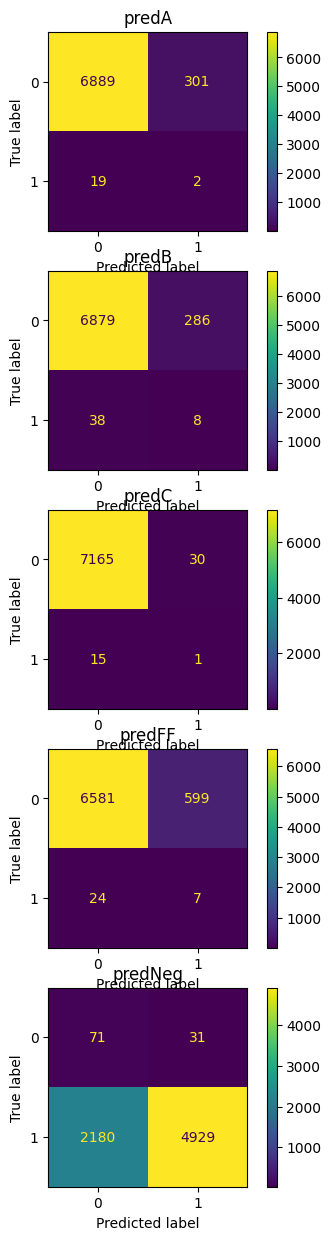

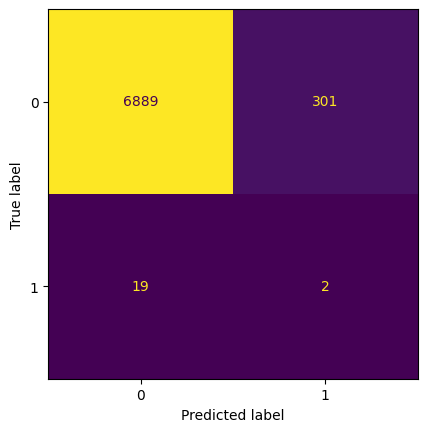

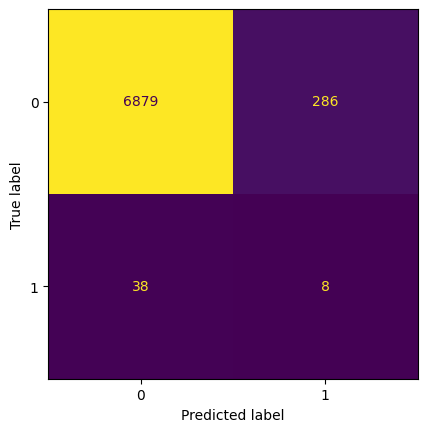

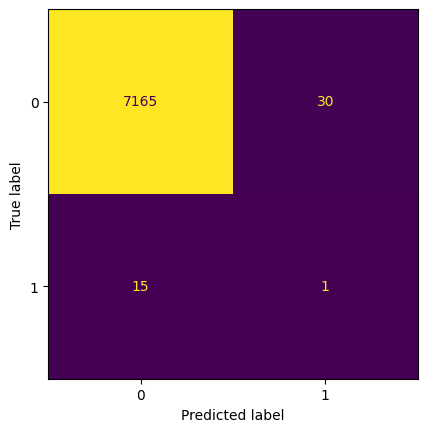

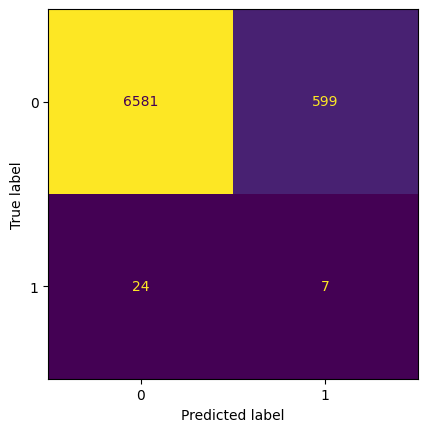

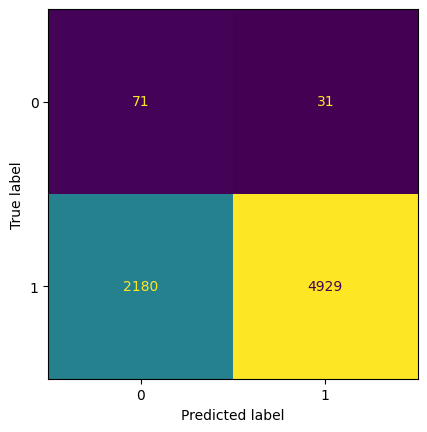

In [28]:
fig, axes = plt.subplots(5,1, figsize=(5,15))

for idx,lab in enumerate(binary_predictions.keys()):
    y_hat = binary_predictions[lab]
    disp = ConfusionMatrixDisplay.from_predictions(y_test[:,idx], y_hat, colorbar = False)
    disp.plot(ax=axes.flat[idx])
    axes.flat[idx].set_title(lab)

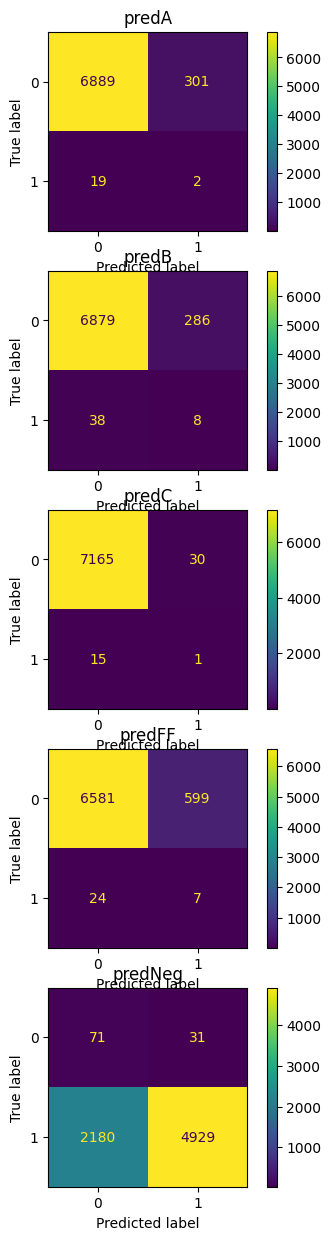

In [29]:
fig

#### Try with conformal predictions 

In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_is_fitted

class ConformalMultilabelClassifier(BaseEstimator, ClassifierMixin):
    """
    A multilabel classifier that uses conformal prediction to generate prediction sets.
    """
    def __init__(self, threshold=0.5):
        self.threshold = threshold
        
    def fit(self, X, y):
        self.X_ = X
        self.y_ = y
        self.classes_ = np.unique(y)
        return self
        
    def predict(self, X):
        check_is_fitted(self)
        # Get the predicted probabilities for each label
        probabilities = self.predict_proba(X)
        # Apply conformal prediction to generate prediction sets
        prediction_sets = [self._conformal_prediction(probs) for probs in probabilities]
        return prediction_sets
    
    def predict_proba(self, X):
        check_is_fitted(self)
        # TODO: Implement your multilabel classification model here
        # For example, you could use a binary relevance approach to fit multiple binary classifiers,
        # or use a single multiclass classifier that outputs a probability matrix
        clf = MultiOutputClassifier(AdaBoostClassifier(n_estimators=100, random_state=0)).fit(X_train.T, y_train)
        probabilities = ... # shape (n_samples, n_labels)
        return probabilities
    
    def _conformal_prediction(self, probs):
        # Compute the p-values for each label
        p_values = np.zeros(len(self.classes_))
        for i, label in enumerate(self.classes_):
            # Compute the empirical null score (ENS) and the significance function for the label
            ens = np.mean(self.y_[:, i] == label)
            signif_func = np.abs(probs[:, i] - ens)
            # Compute the p-value as the proportion of samples with significance function greater than or equal to the current sample
            p_values[i] = np.mean(signif_func >= np.abs(probs[:, i] - ens))
        # Compute the rejection threshold as (1 - alpha)
        alpha = 0.1 # significance level
        rejection_threshold = 1 - alpha
        # Generate the prediction set as the set of labels with p-values less than or equal to the rejection threshold
        prediction_set = set(self.classes_[p_values <= rejection_threshold])
        return prediction_set